In [1]:
import os
import openai
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
import logging
import sys
import re
from tqdm import tqdm
from IPython.display import HTML
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import json
from datasets import _transform, get_full_class_labels, fix_class_names, idx_to_label, CUBDataset
openai.api_key  = os.getenv('OPENAI_API_KEY')

# Dataset

In [2]:
CUB_DIR = '/home/kush/Desktop/CLIP/CUB/CUB_200_2011' # REPLACE THIS WITH YOUR OWN PATH
# load CUB dataset
data_dir = pathlib.Path(CUB_DIR)
cub_dataset = CUBDataset(data_dir, train=True, transform=_transform(224))

/home/kush/anaconda3/envs/kush/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


# Load model

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

# Function for computing Label text emebddings

In [4]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

# Function for index to label

In [5]:
def idx_to_label(label_to_idx):
    dataset_items = list(label_to_idx.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [6]:
def initialize_counter_dict(labels):
    dict_ = dict()
    for label1 in labels:
        dict_[label1] = dict()
        for label2 in labels:
            dict_[label1][label2] = 0
    return dict_

In [7]:
def increase_count(counter_dict, actual_class, top_classes):
    for class_ in top_classes:
        counter_dict[actual_class][class_] += 1
    return counter_dict

In [18]:
def add_to_counter_dict(counter_dict, index_to_class_dict, actual_index_list, 
                        pred_index_list):
    for idx, actual_class_index in enumerate(actual_index_list):
        actual_class = index_to_class_dict[int(actual_class_index)]
        top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               pred_index_list[idx]))
        counter_dict = increase_count(counter_dict, actual_class, top_classes)
    return counter_dict

# Calculate CLIP accuracy

In [26]:
def calc_acc(model, dataset, descriptions, batch_size = 64*10, count_classes = False, 
             topK = 5):
    
    
    topK_is_one = False
    if topK == 1:
        topK = 5
        topK_is_one = True
    elif topK < 1:
        return "Please use k >= 1!"
    
    
    
    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    
    
    encodings = compute_encodings(model, descriptions)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_topk = torchmetrics.Accuracy(top_k=topK, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        if topK_is_one == True:
            org_topK = 1
        topk_values, topk_indices = image_labels_similarity.topk(topK, dim=1)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_topk = clip_accuracy_metric_topk(image_labels_similarity, labels)
        
        
        if count_classes == True:
            count_classes_dict = add_to_counter_dict(count_classes_dict, index_to_class_dict,
                                                 labels, topk_indices)


    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs[f"Total CLIP-Standard Top-{5} Accuracy: "] = 100*clip_accuracy_metric_topk.compute().item()
    
    if count_classes == True:
        for actual_key in count_classes_dict.keys():
            count_classes_dict[actual_key] = sorted(count_classes_dict[actual_key].items(),
                                                key=lambda x: x[1], reverse=True)

        json_string = json.dumps(count_classes_dict, indent=4)  # indent for pretty formatting

        # Write JSON string to a text file
        with open(f'top{topK}_cub.json', 'w') as file:
            file.write(json_string)

    
    return accuracy_logs

In [27]:
calc_acc(model, cub_dataset, cub_dataset.classes,
         count_classes = True, topK = 1)

100%|███████████████████████████████████████████| 10/10 [00:42<00:00,  4.27s/it]


{'Total CLIP-Standard Top-1 Accuracy: ': 62.39572763442993,
 'Total CLIP-Standard Top-5 Accuracy: ': 90.17350673675537}

# Graphs

In [28]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


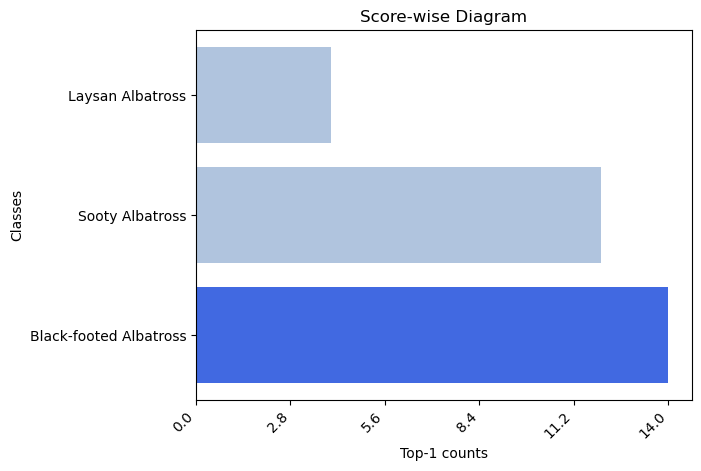

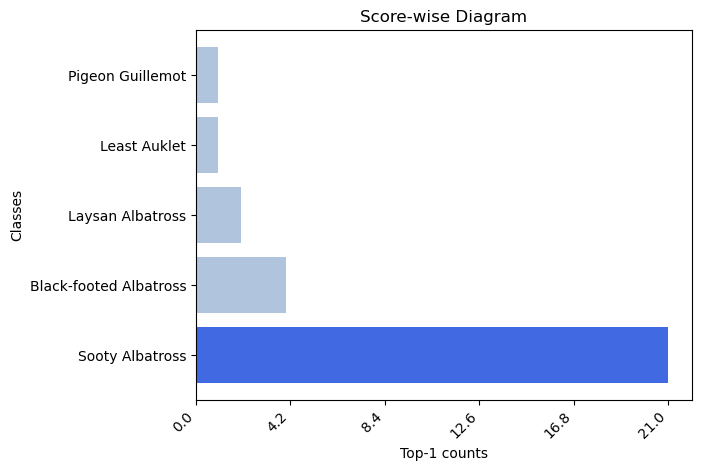

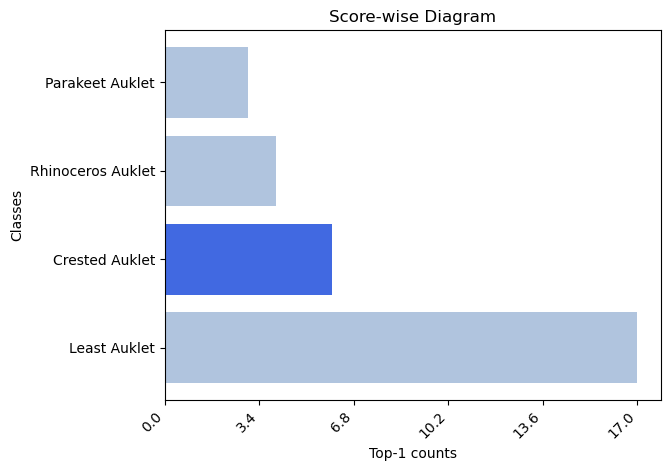

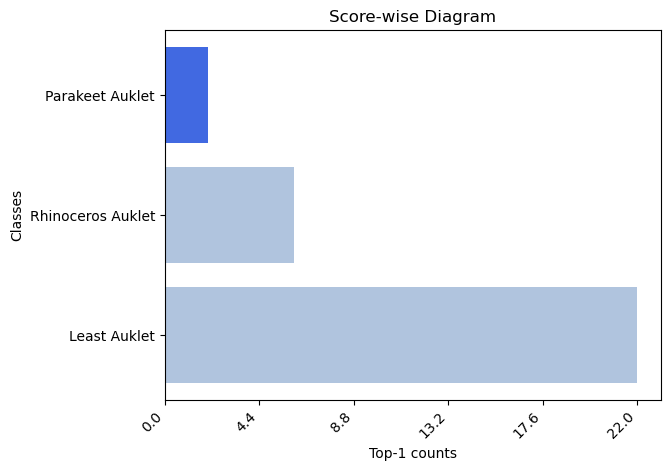

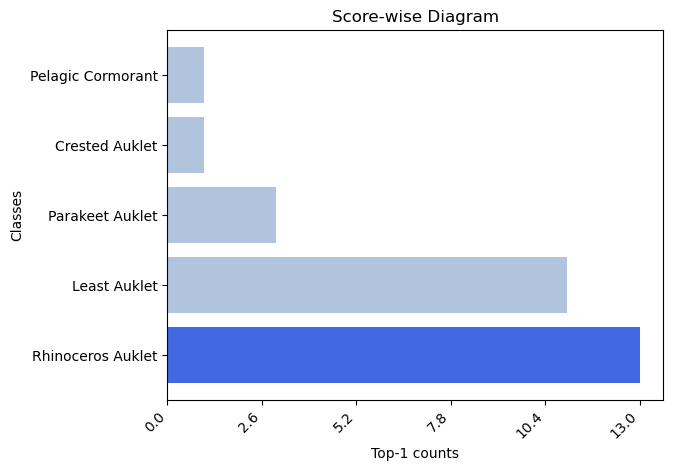

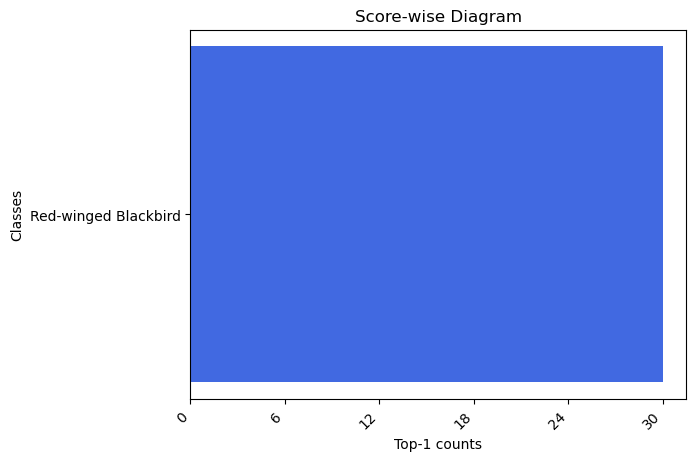

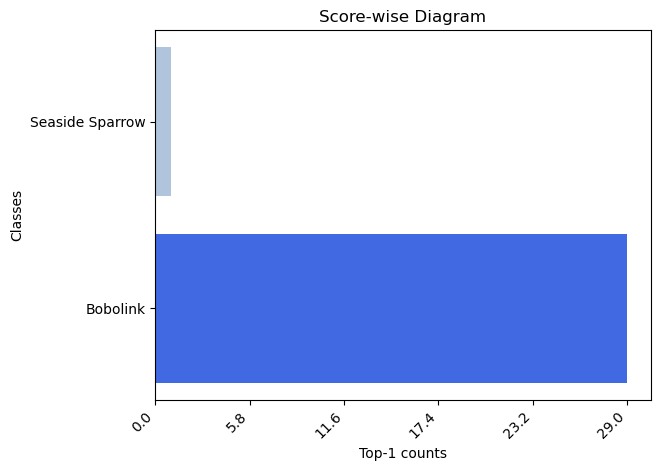

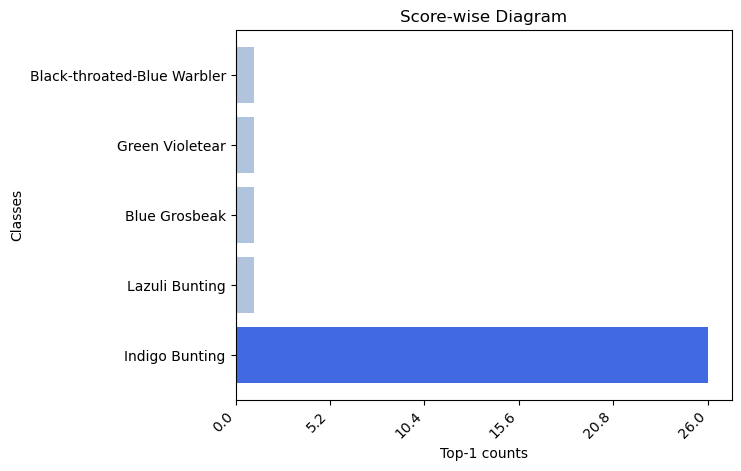

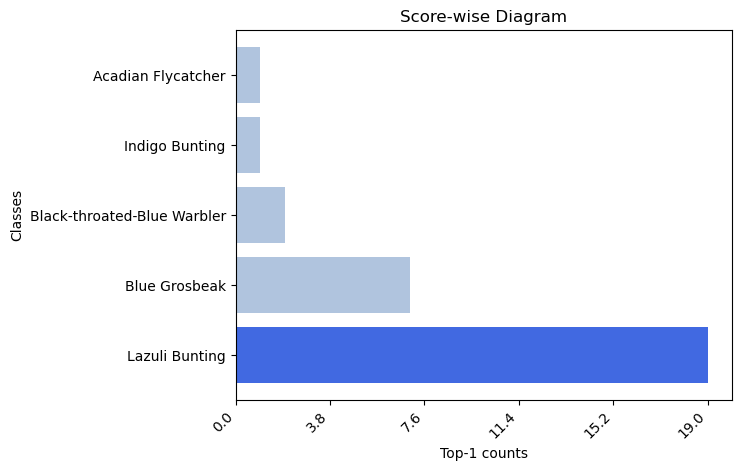

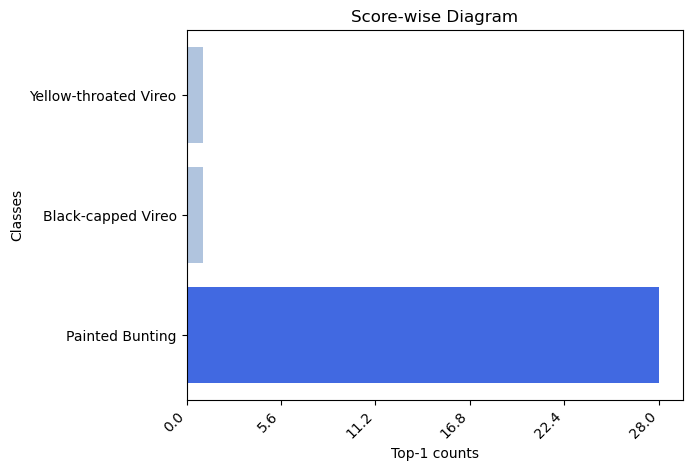

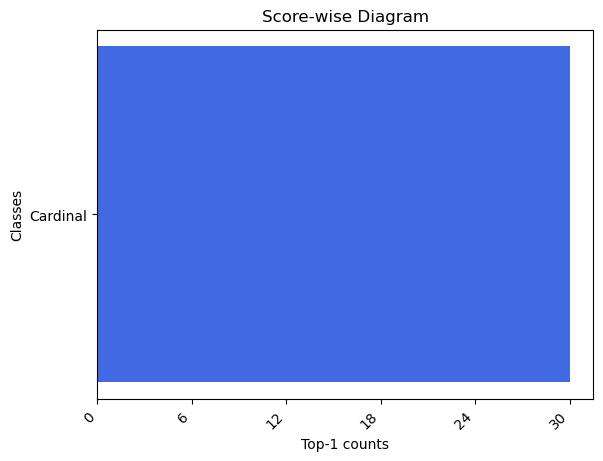

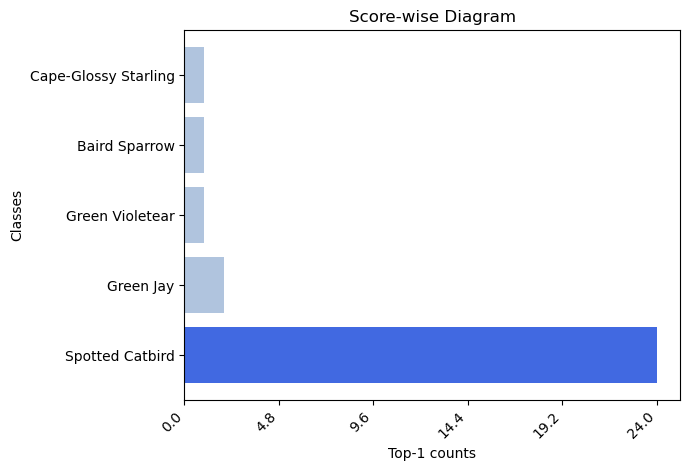

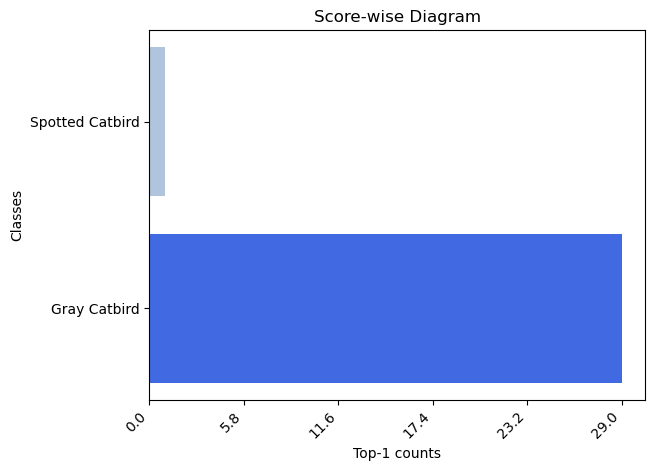

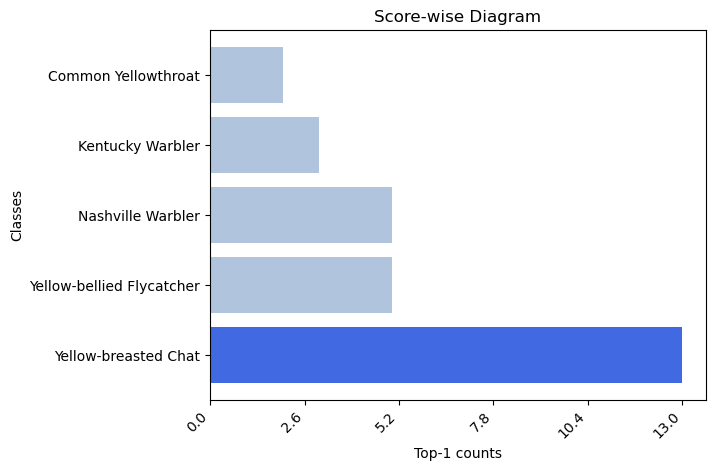

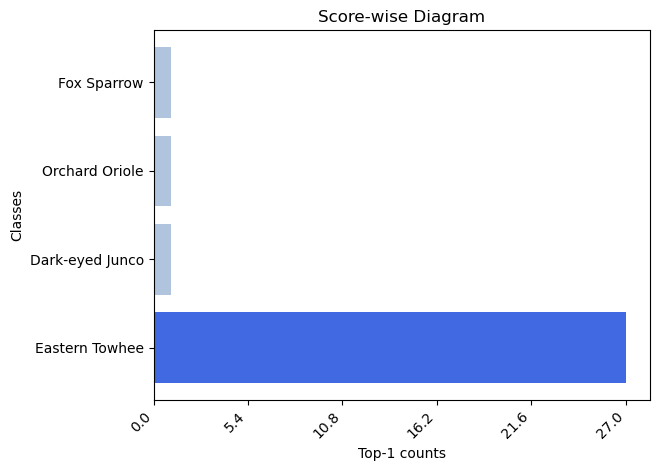

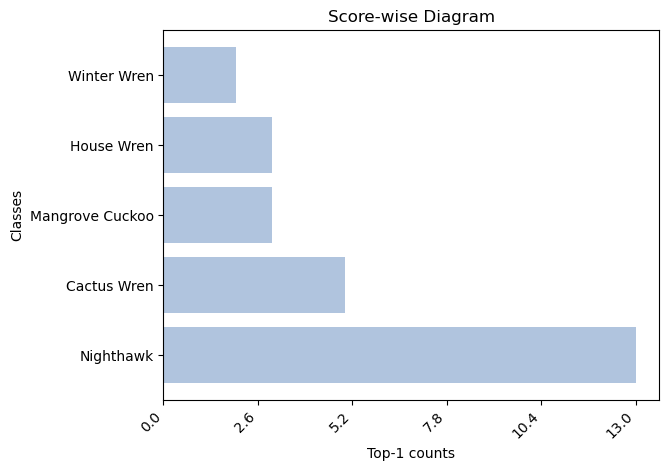

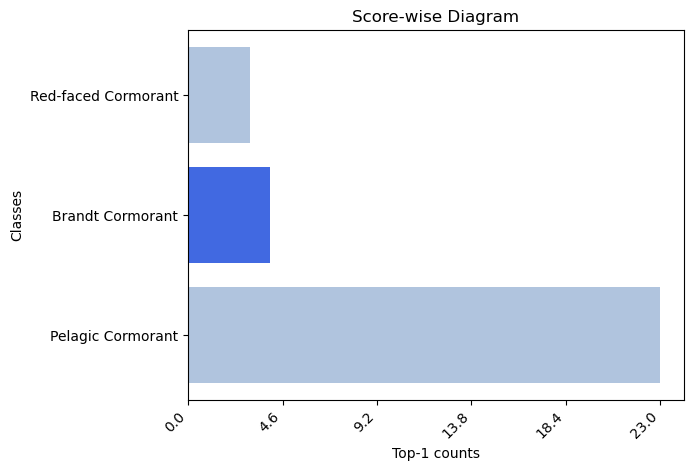

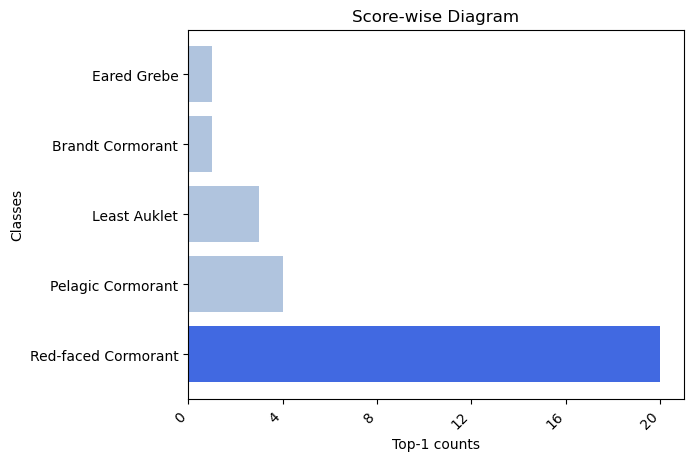

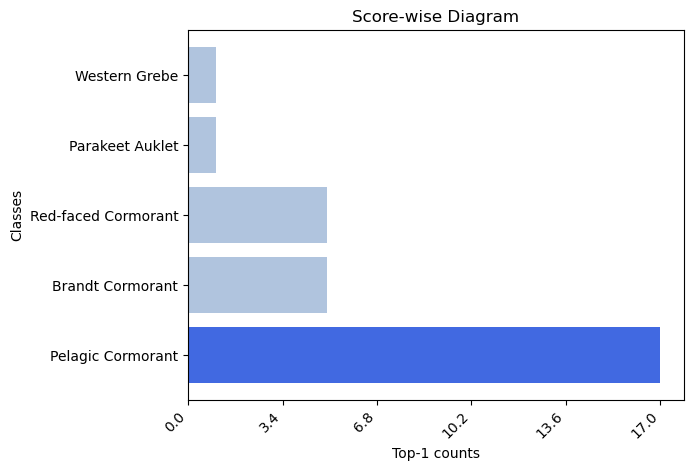

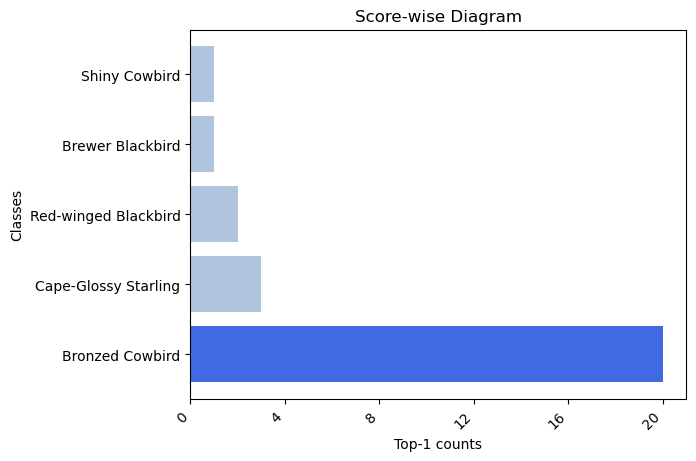

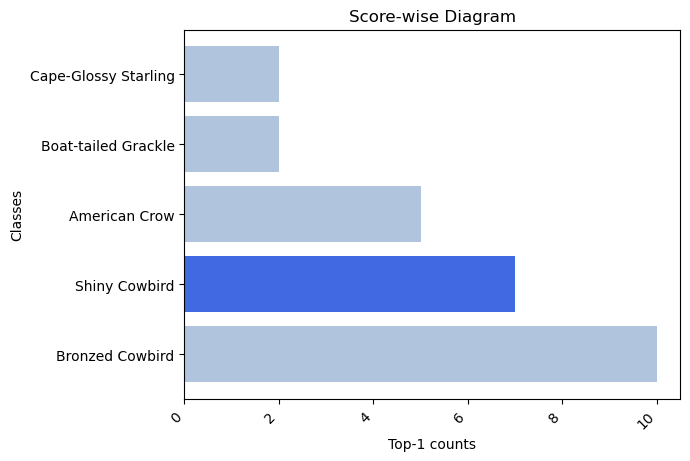

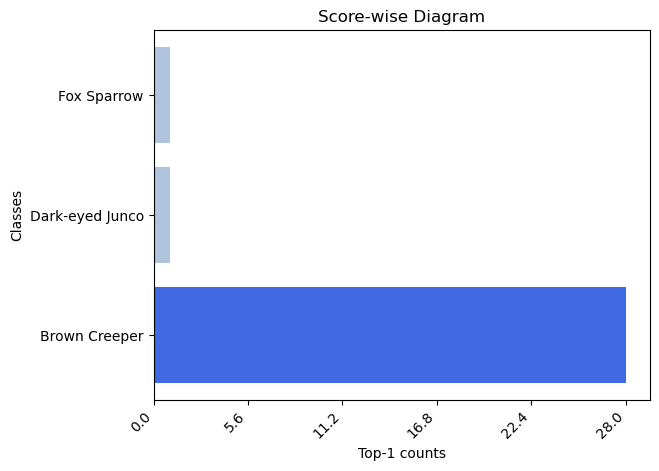

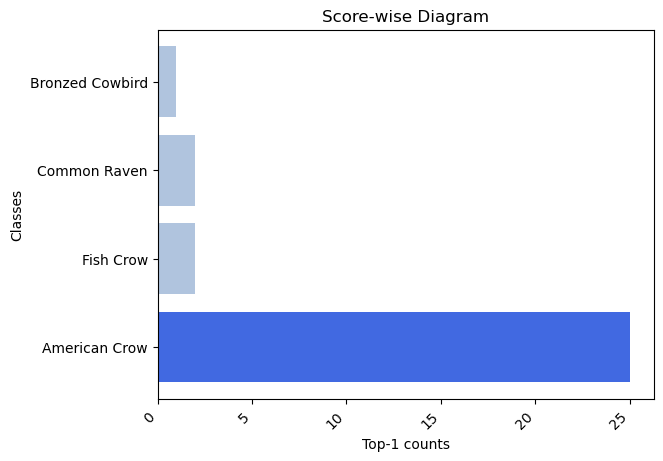

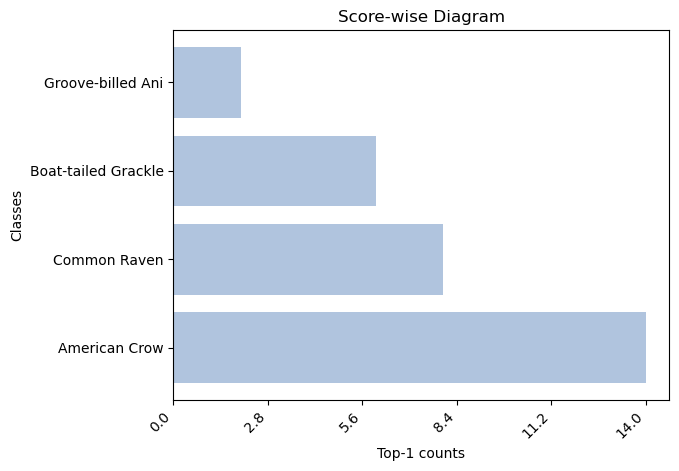

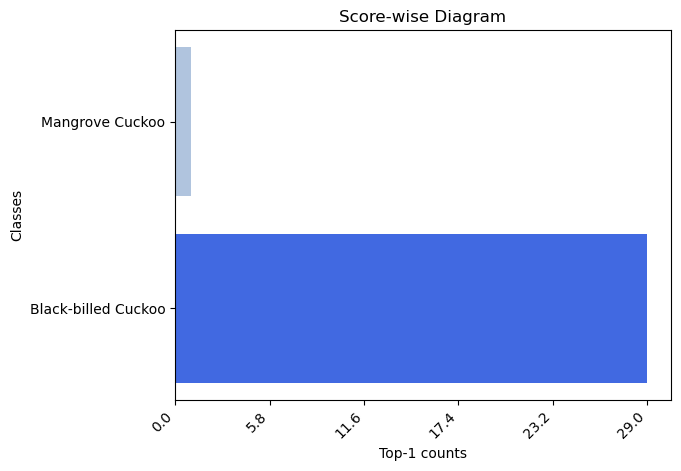

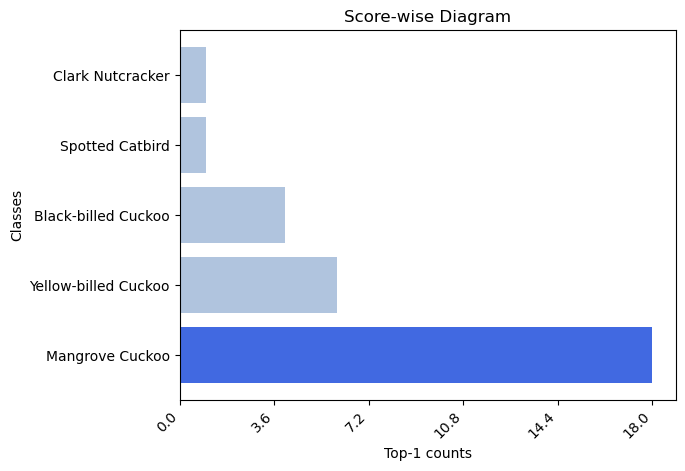

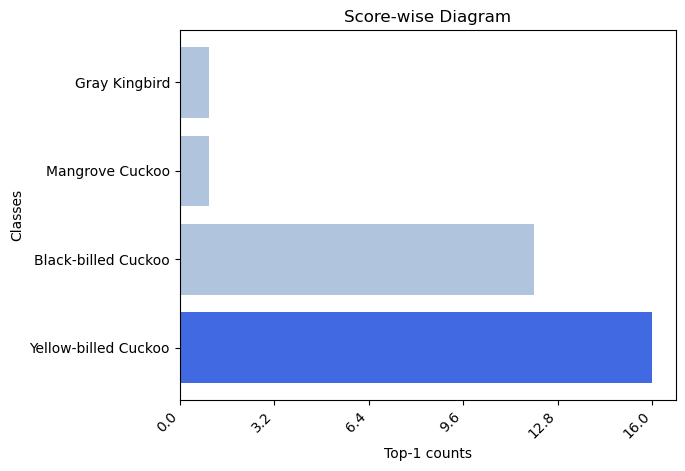

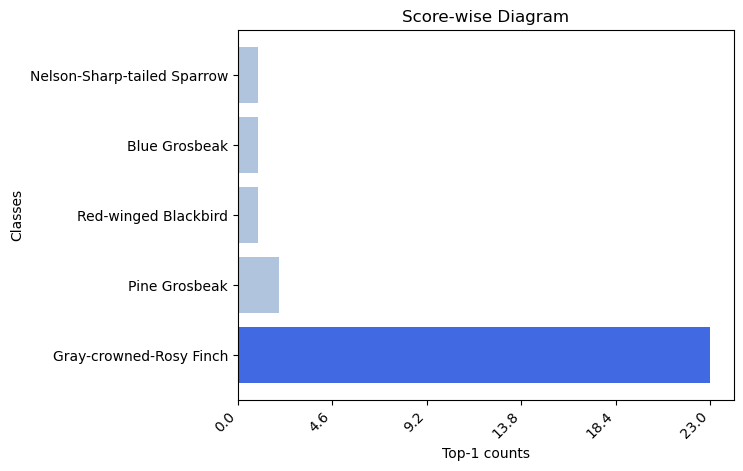

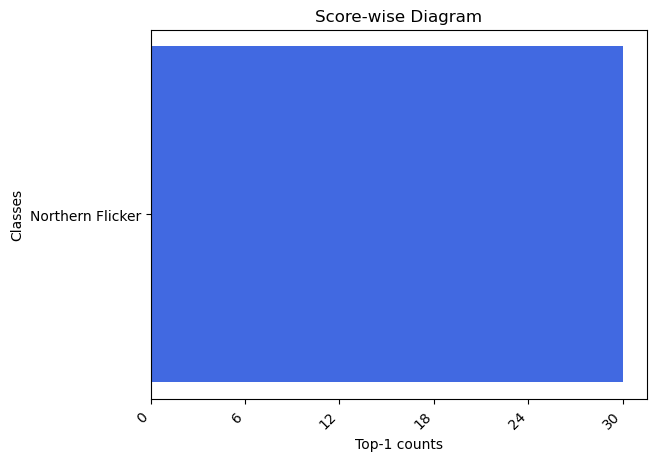

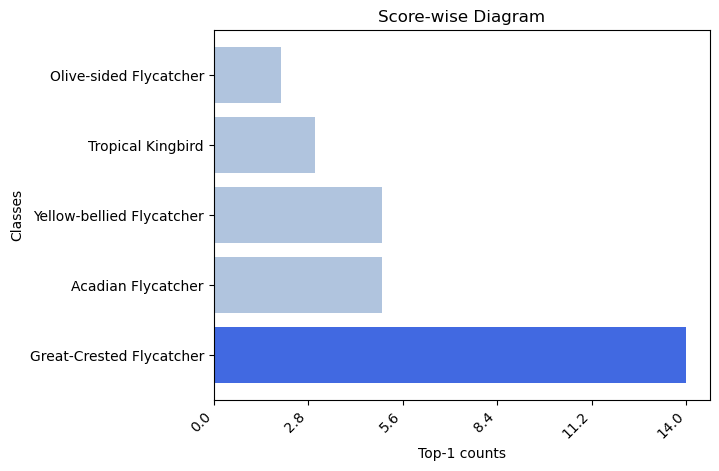

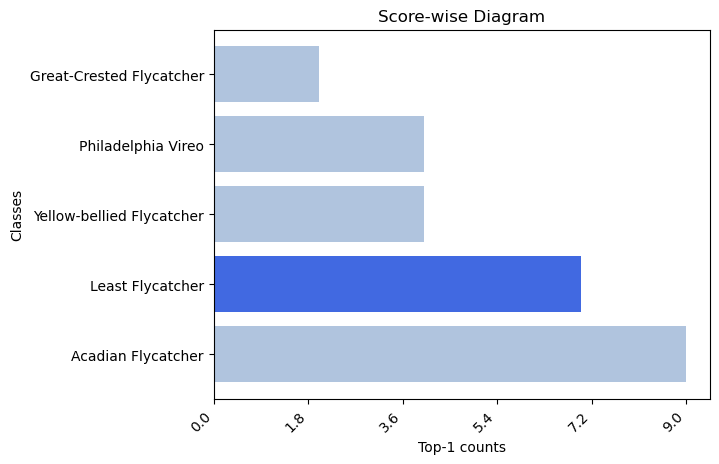

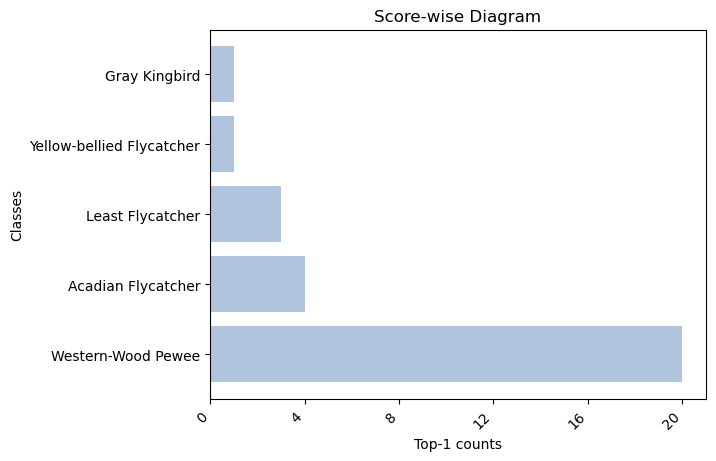

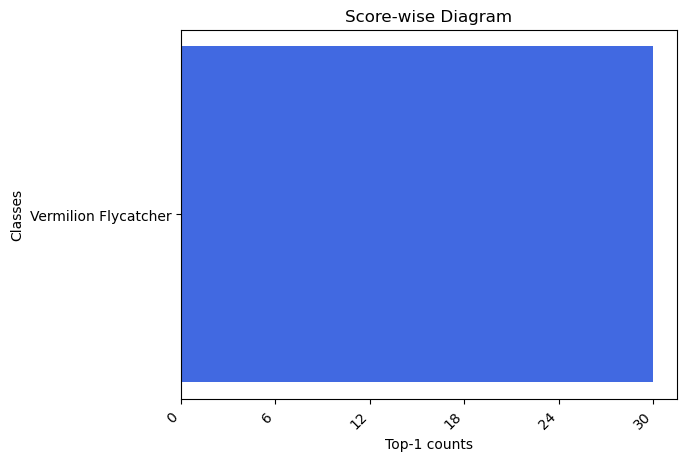

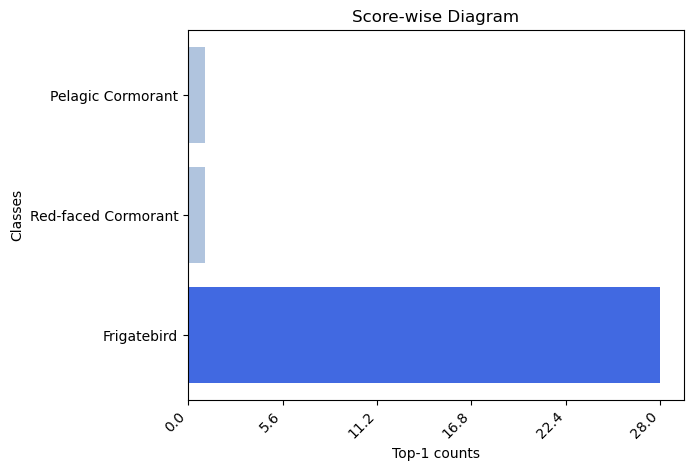

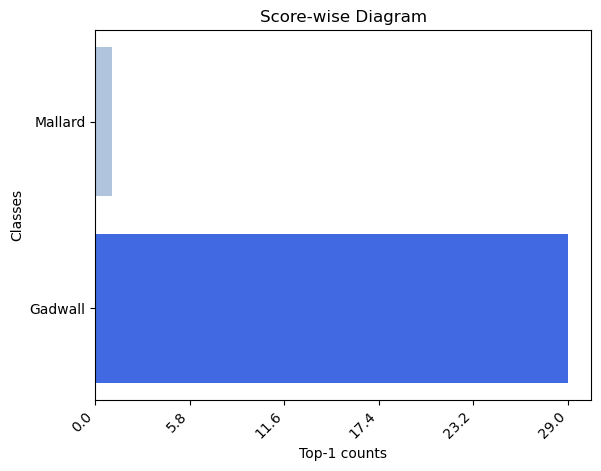

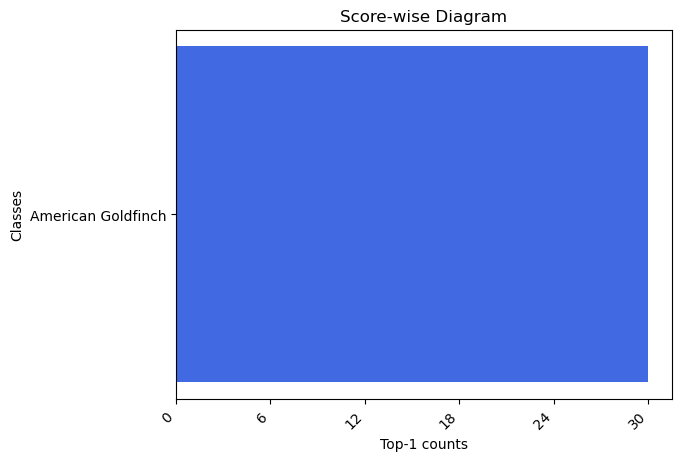

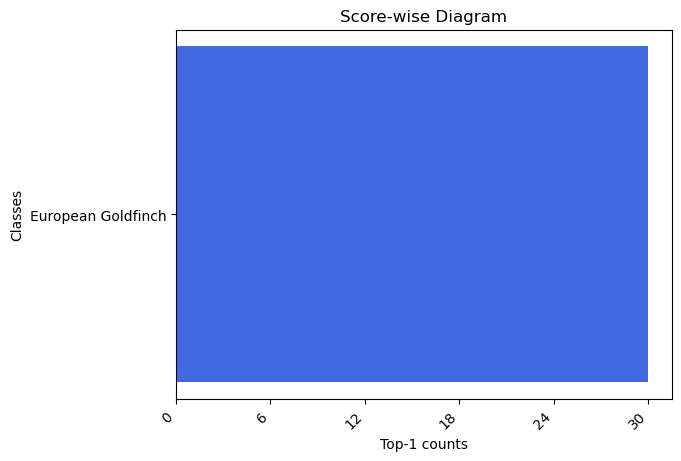

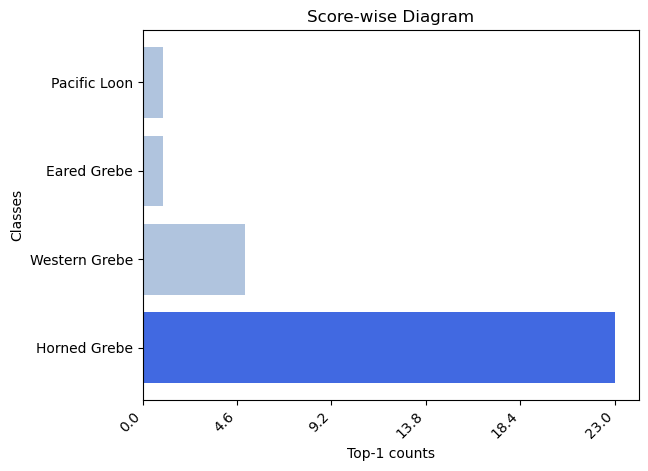

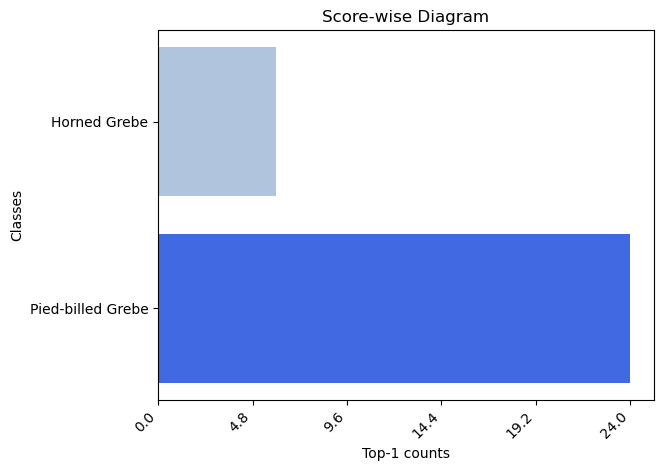

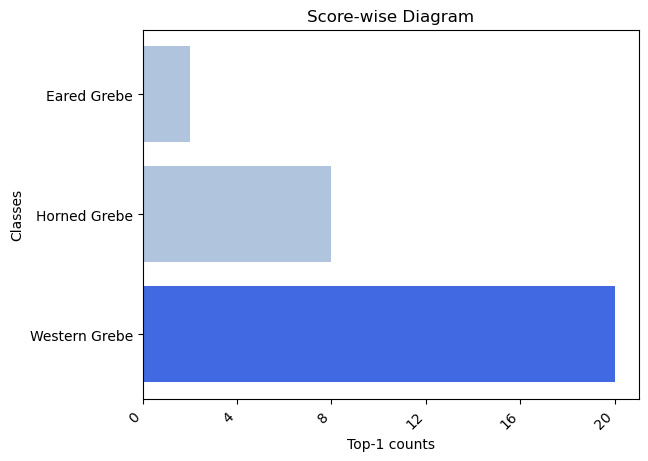

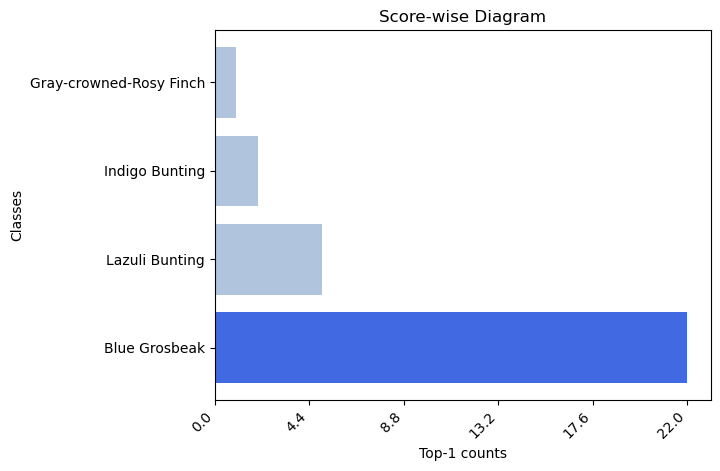

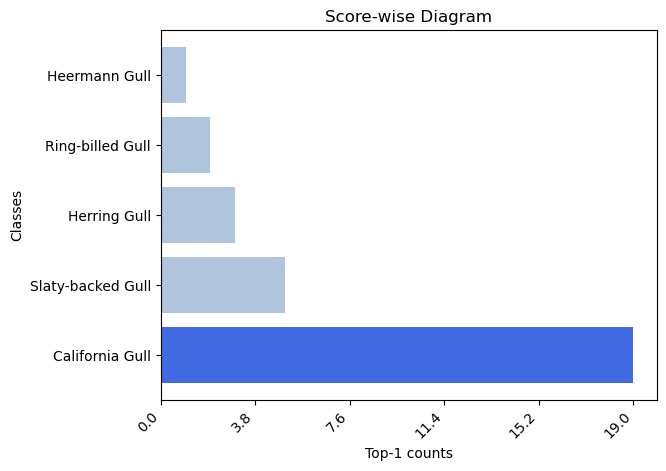

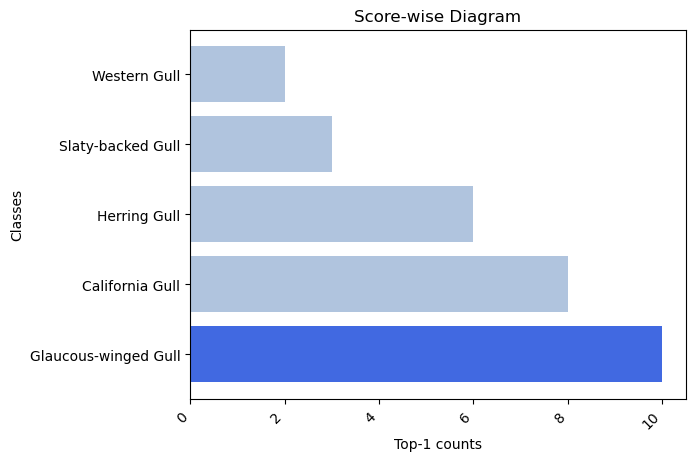

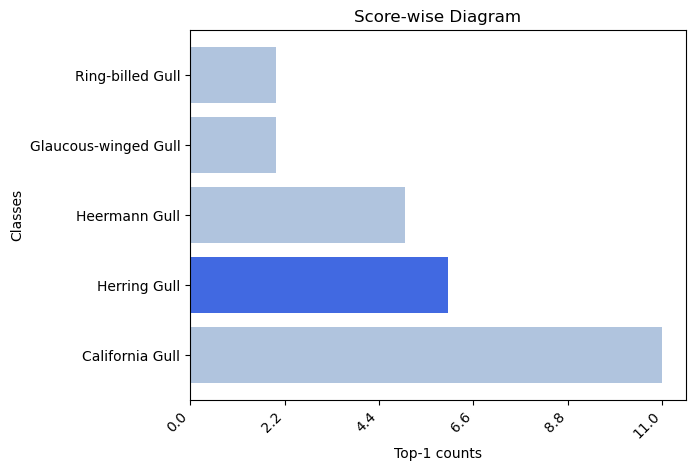

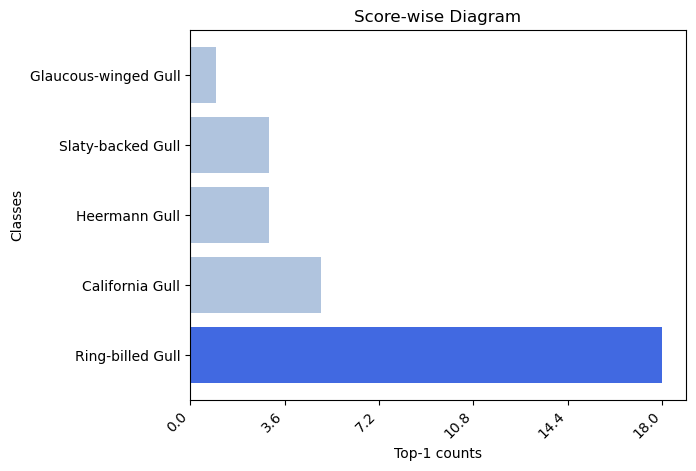

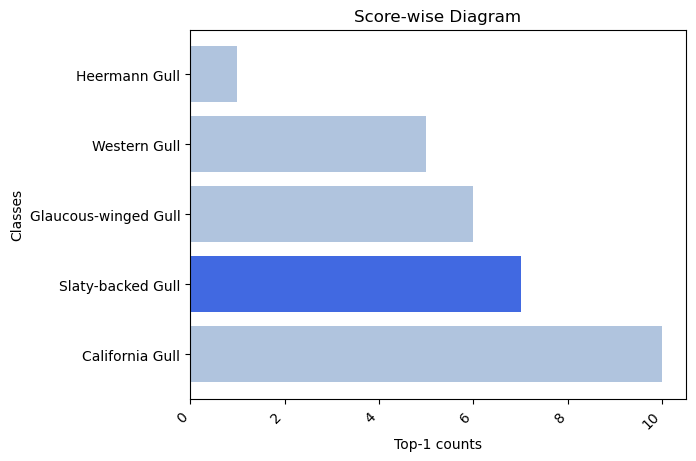

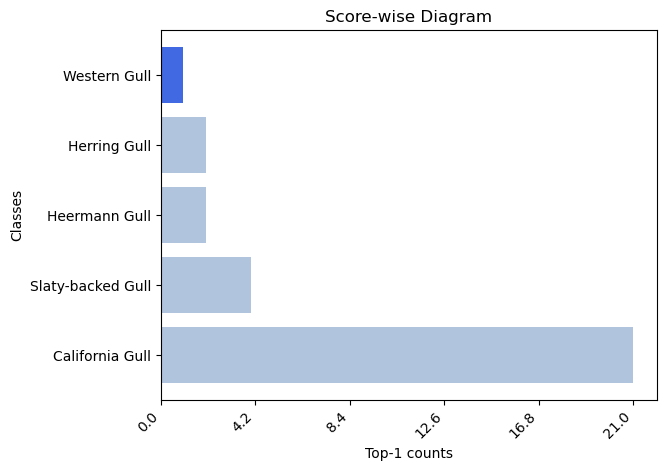

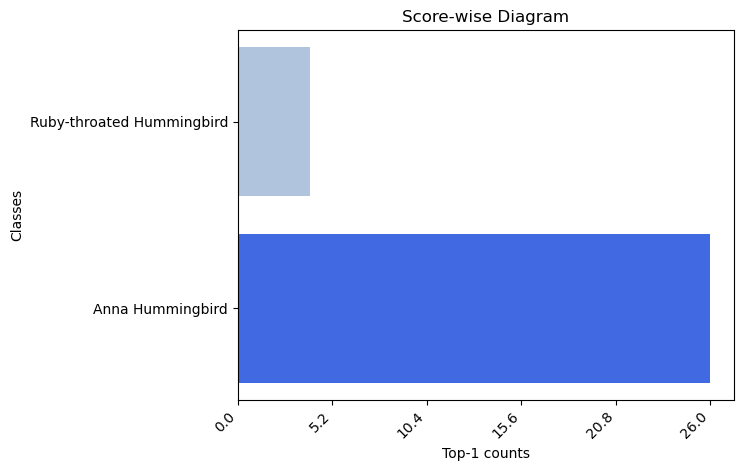

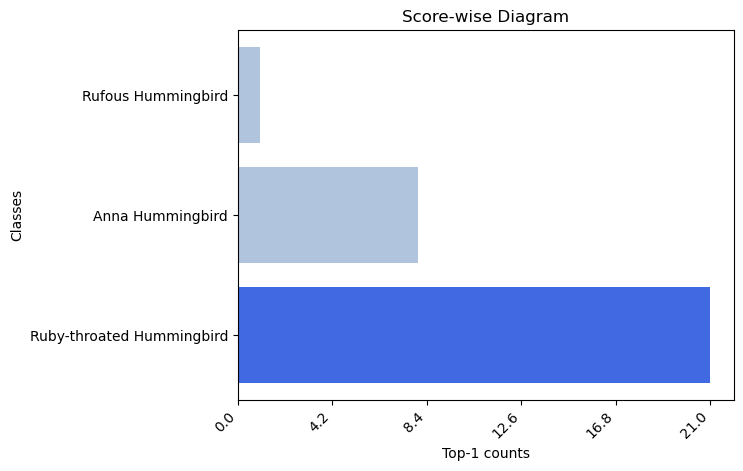

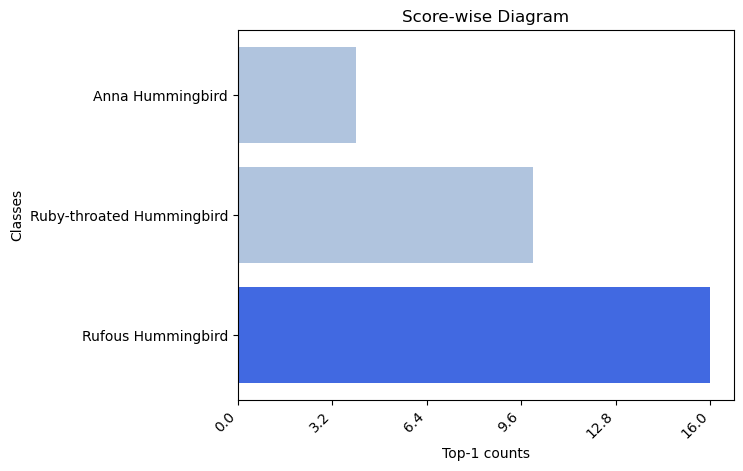

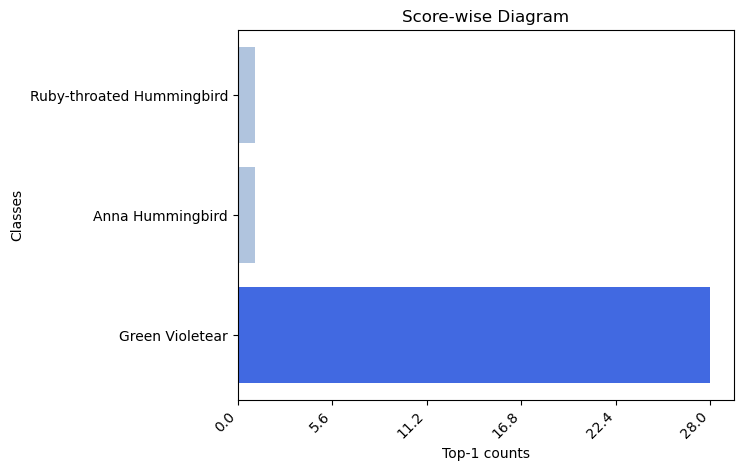

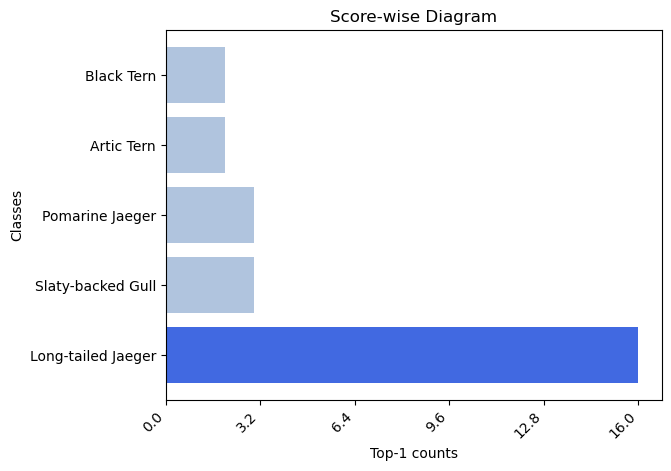

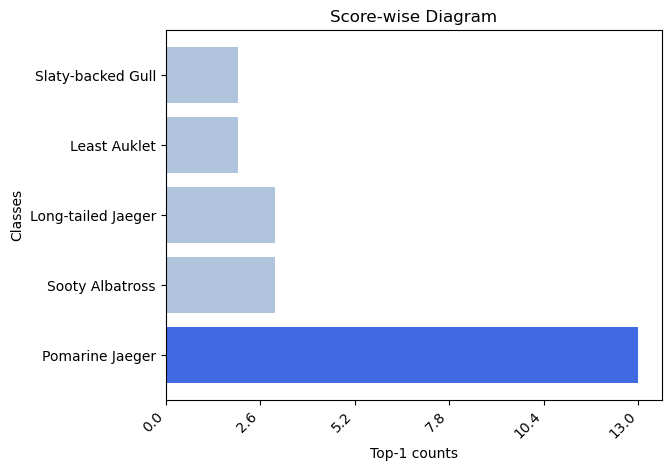

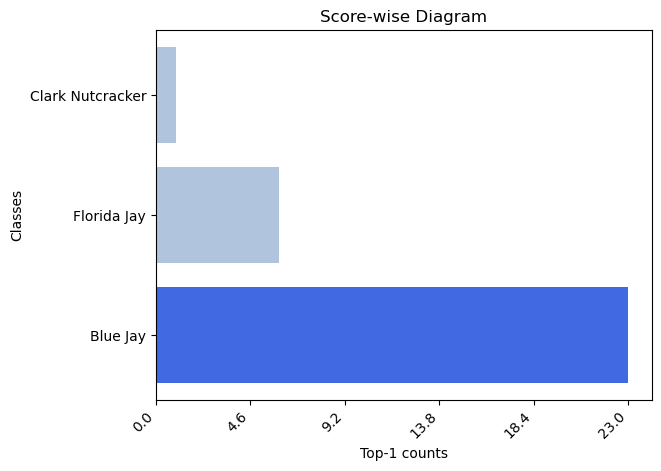

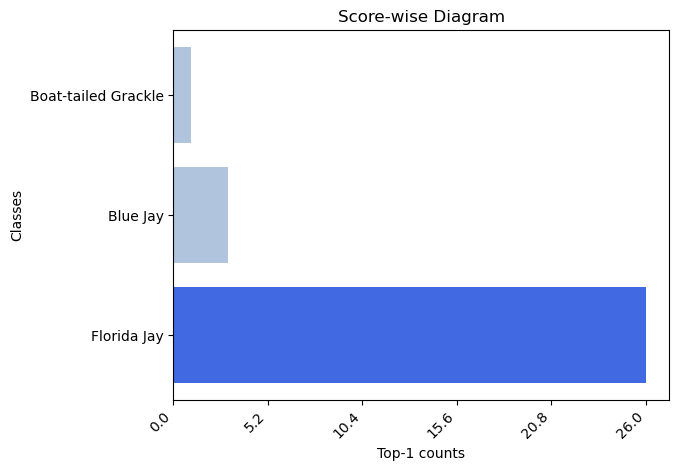

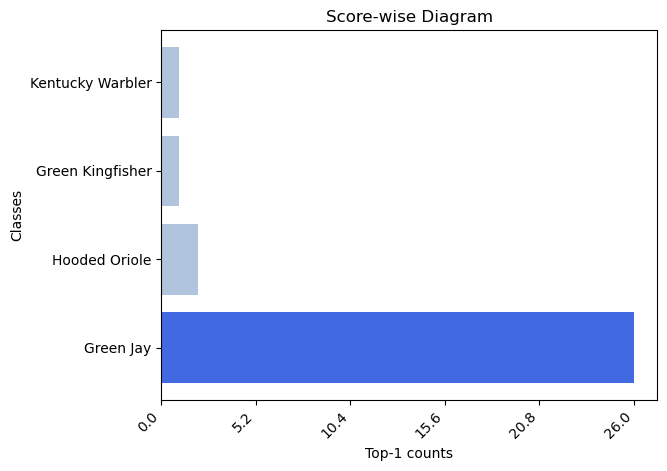

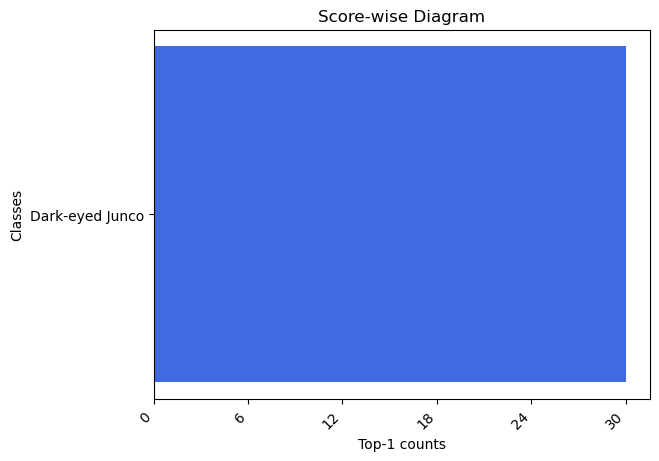

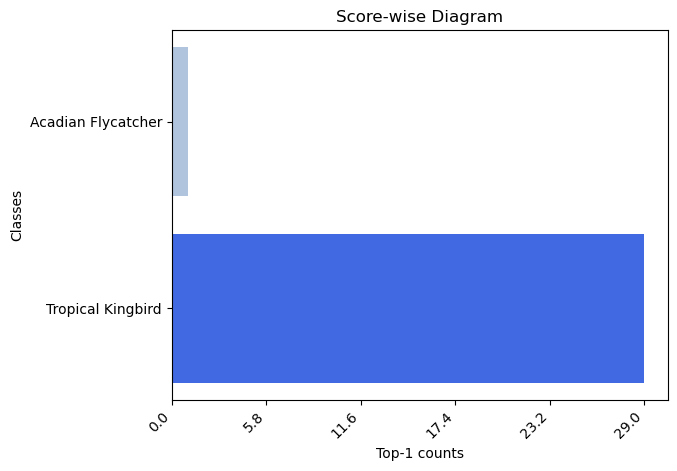

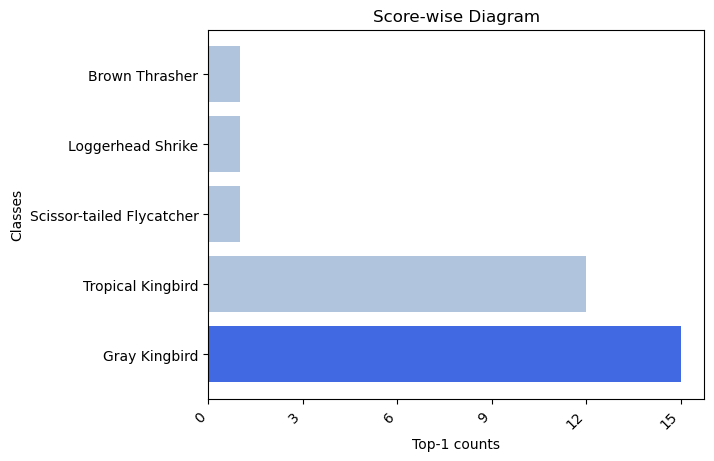

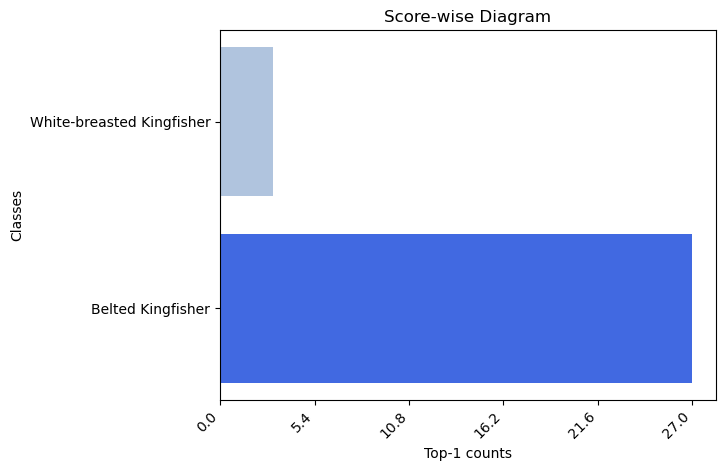

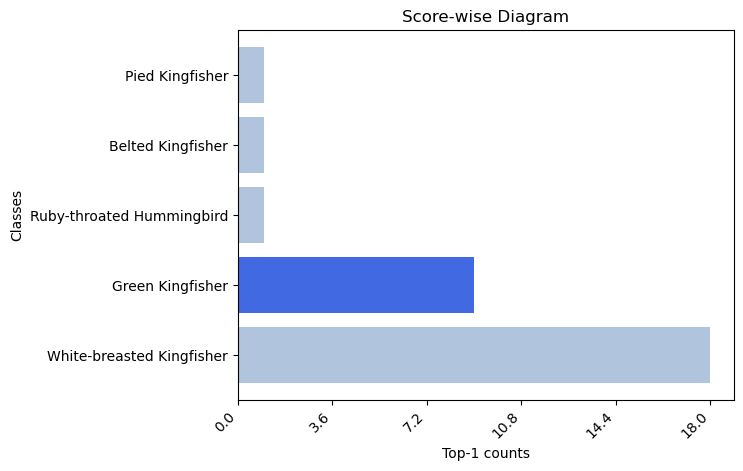

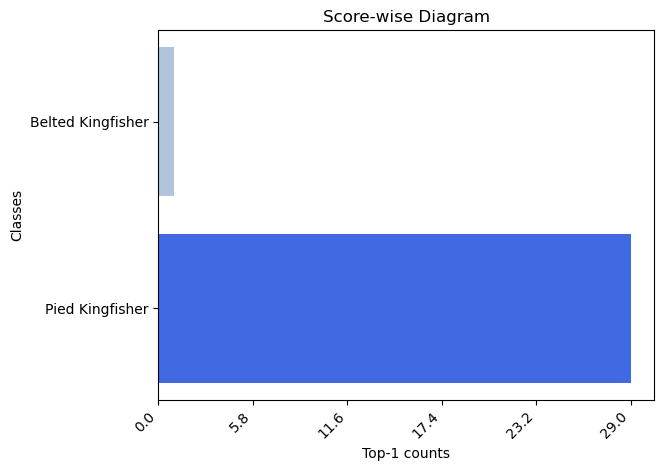

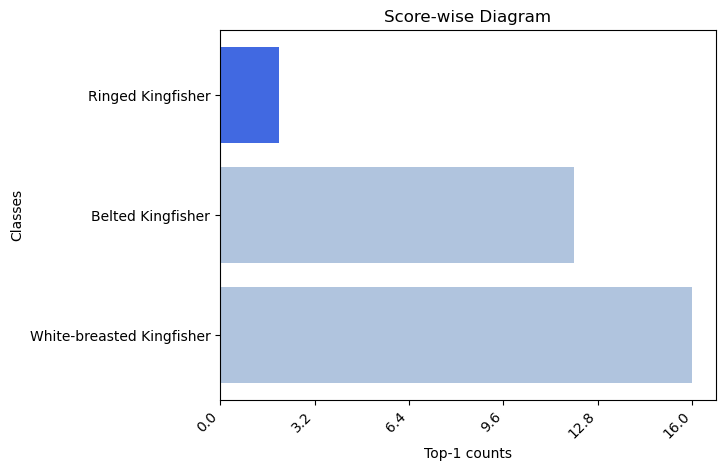

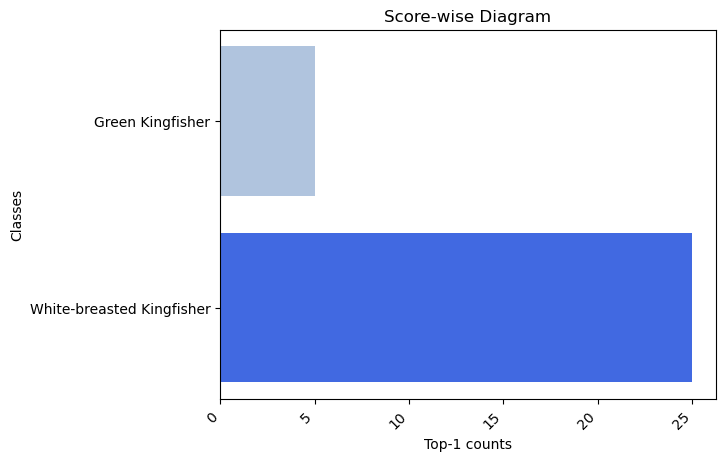

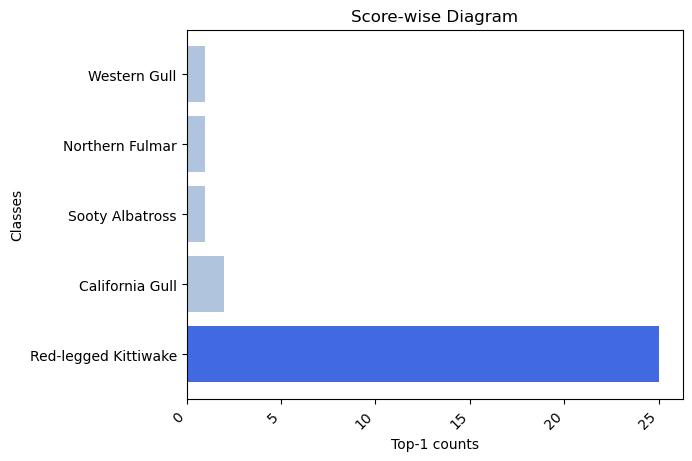

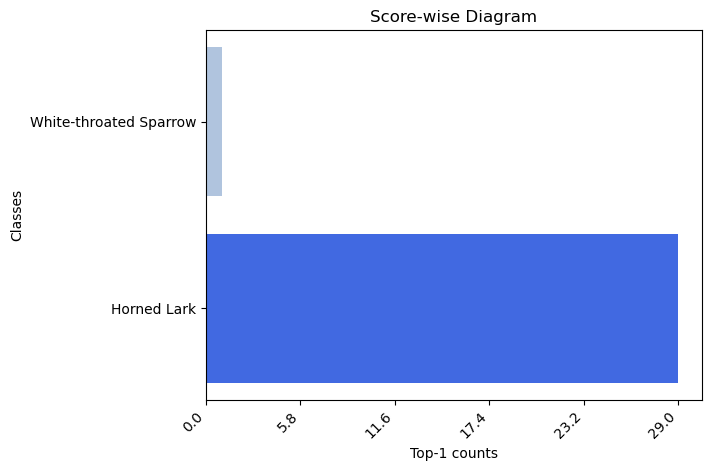

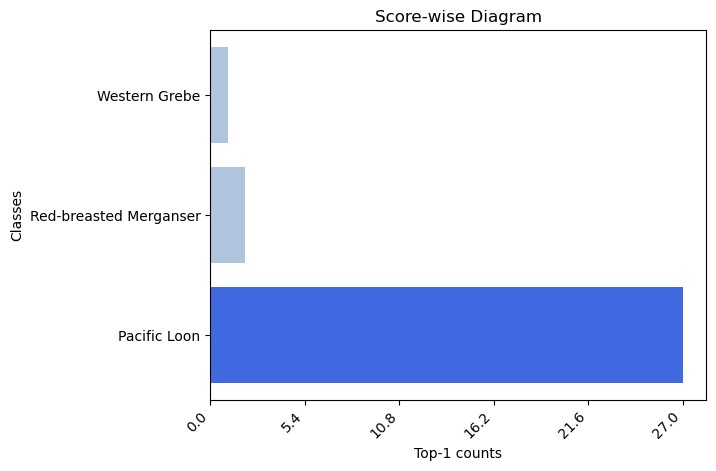

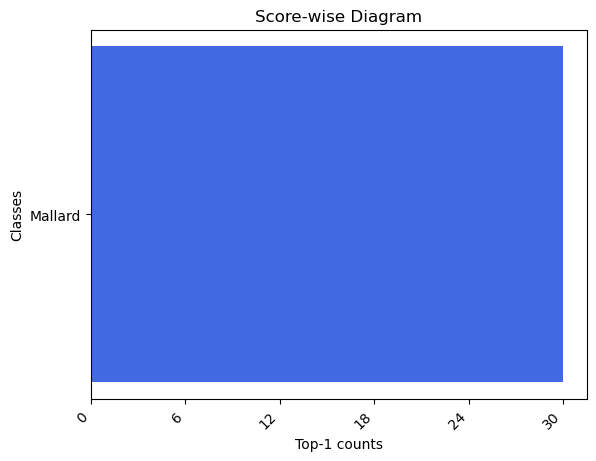

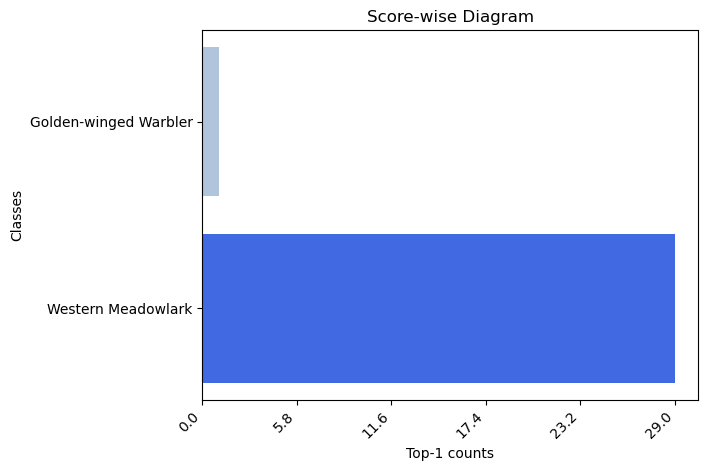

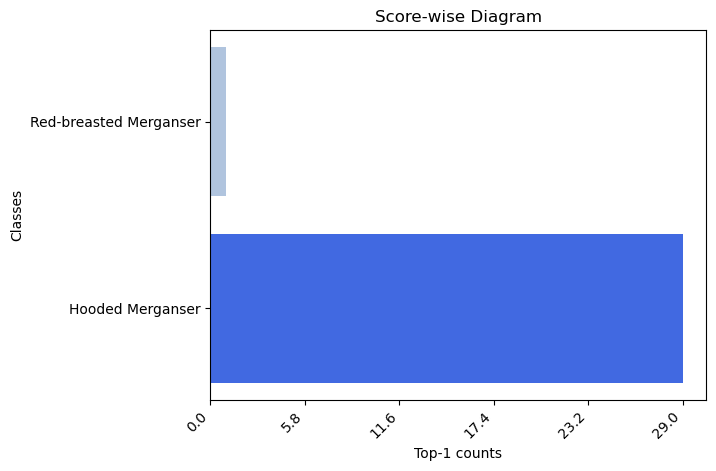

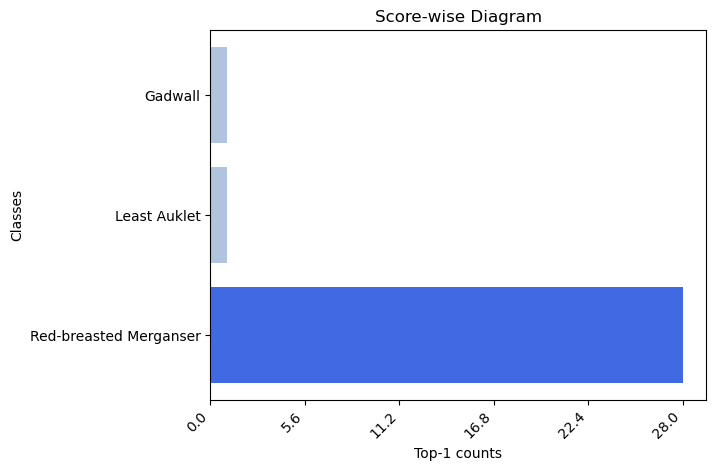

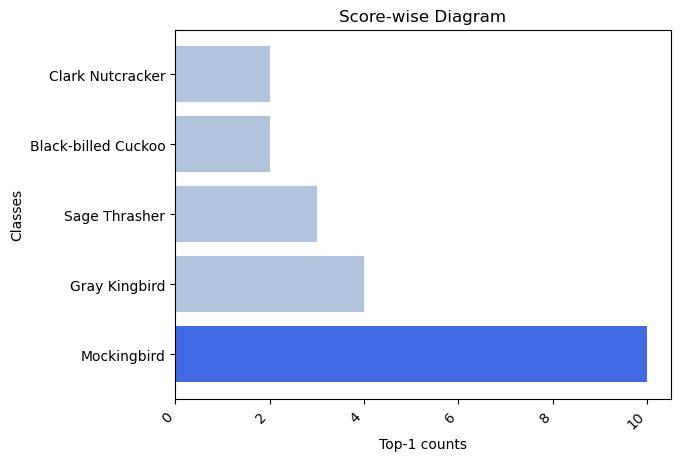

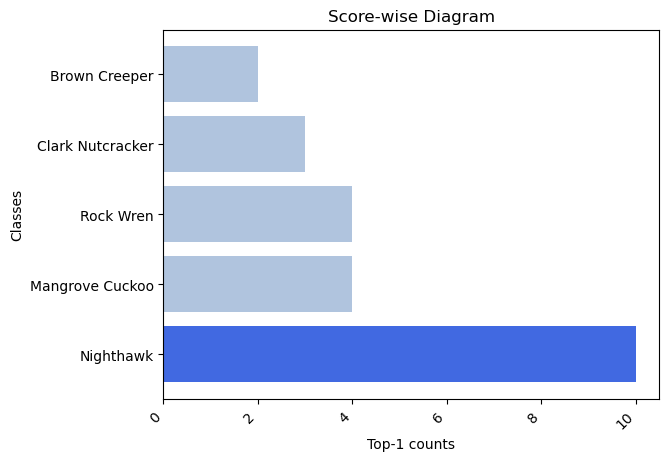

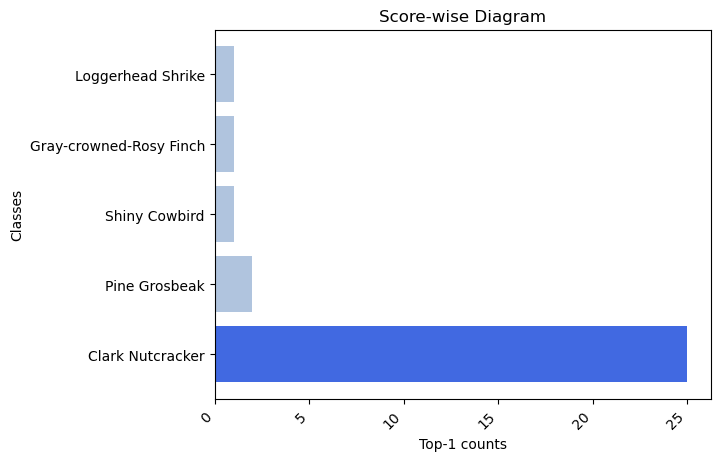

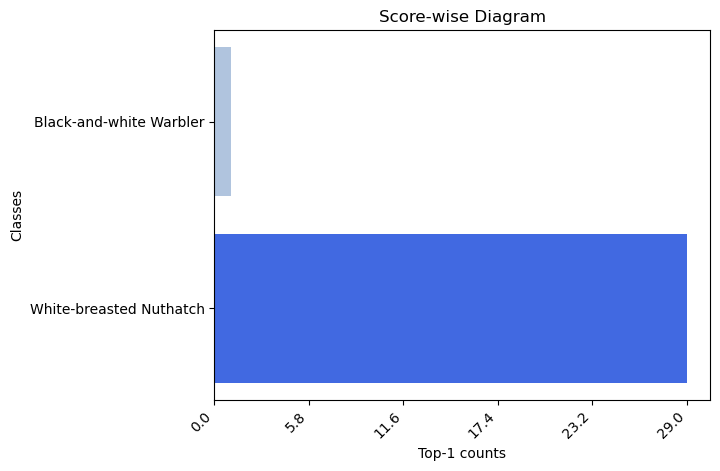

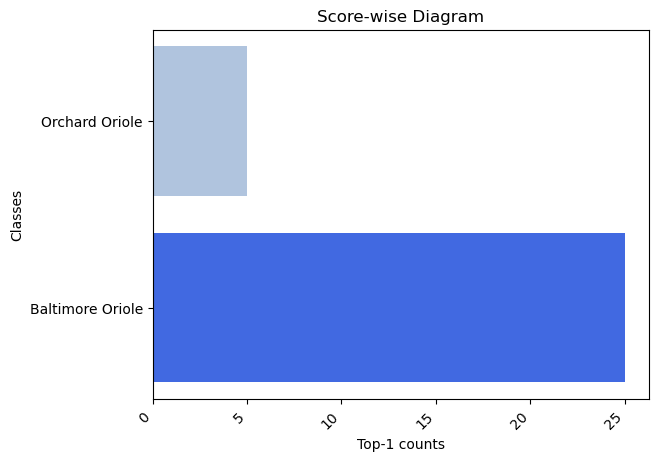

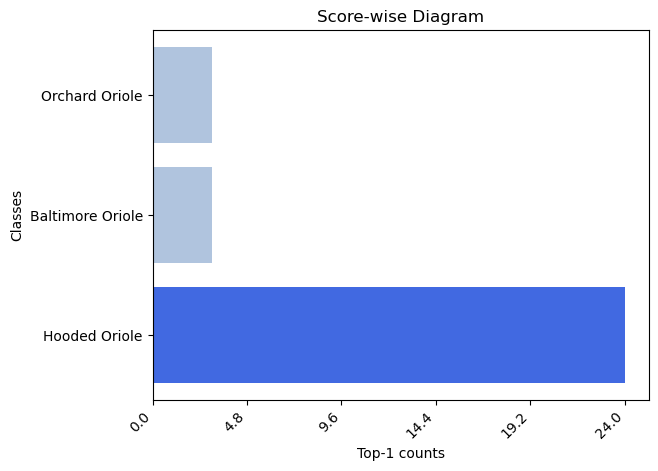

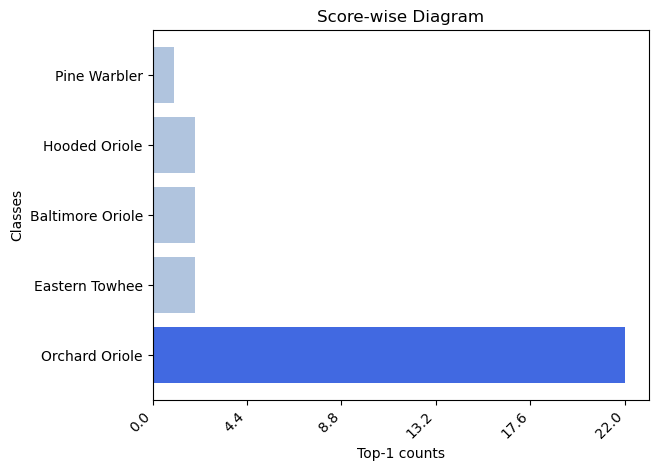

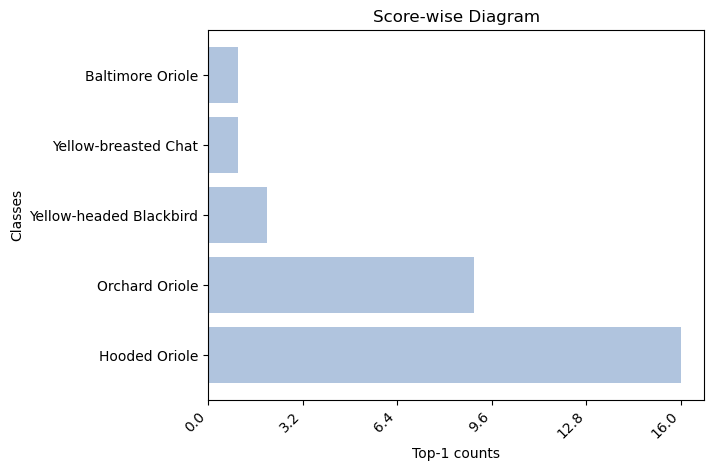

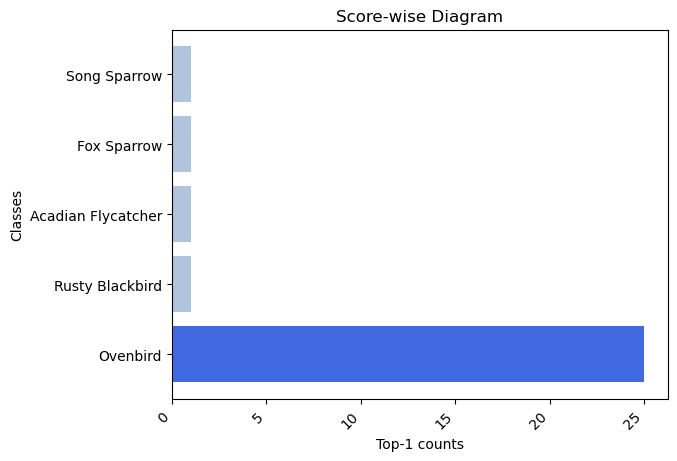

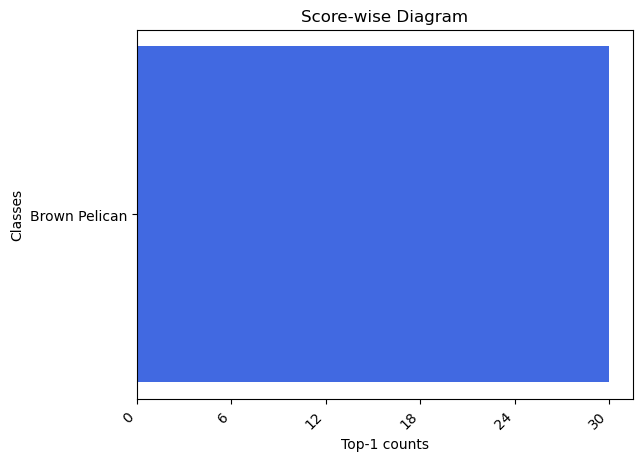

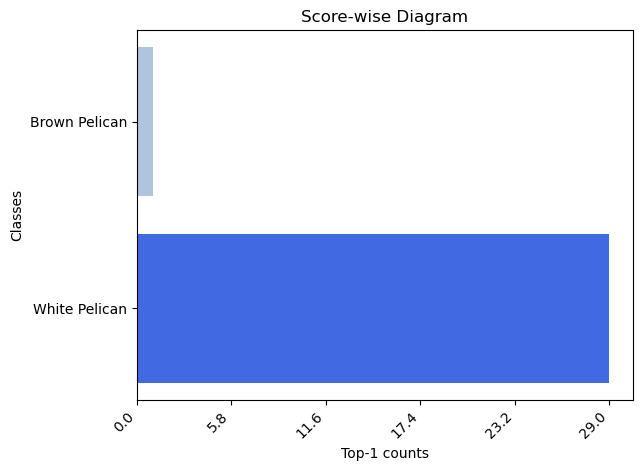

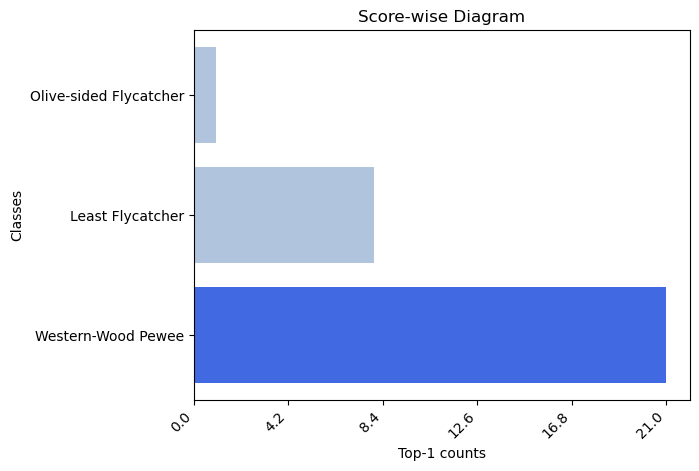

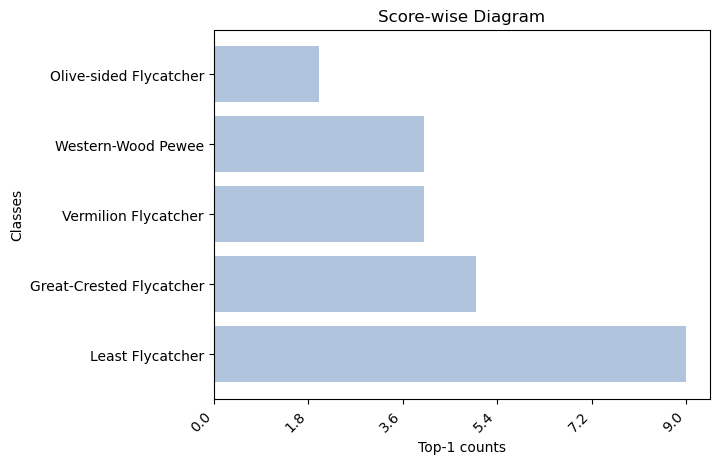

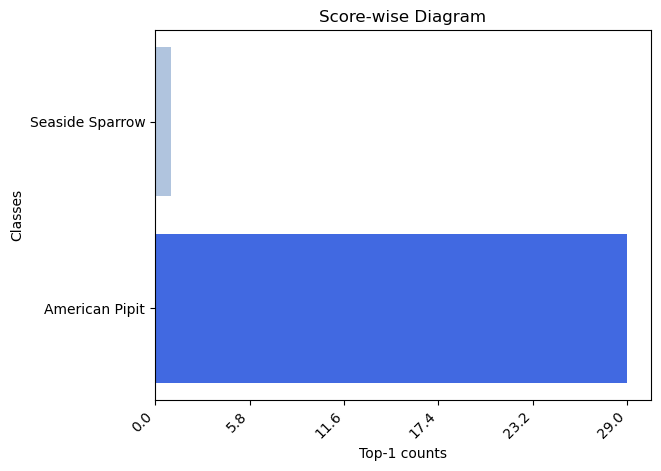

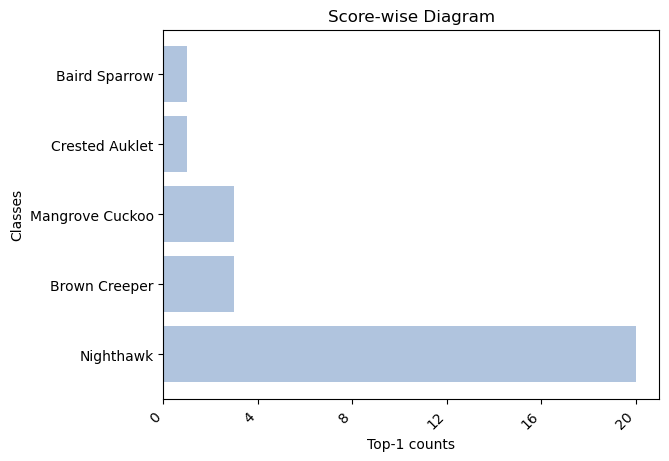

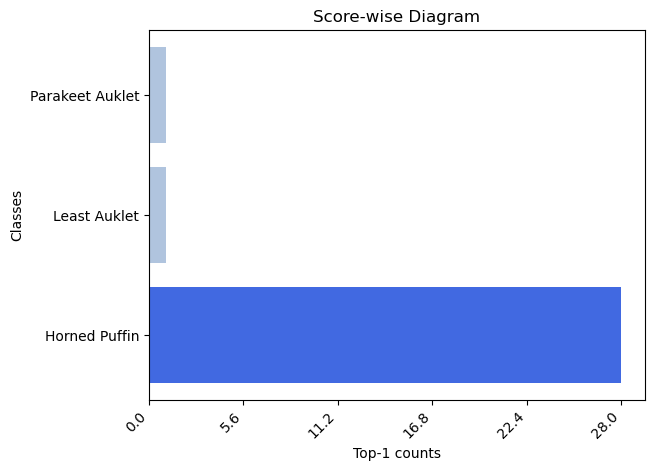

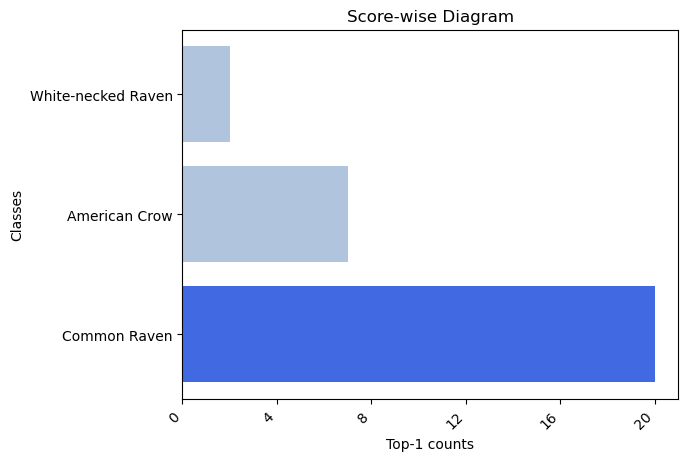

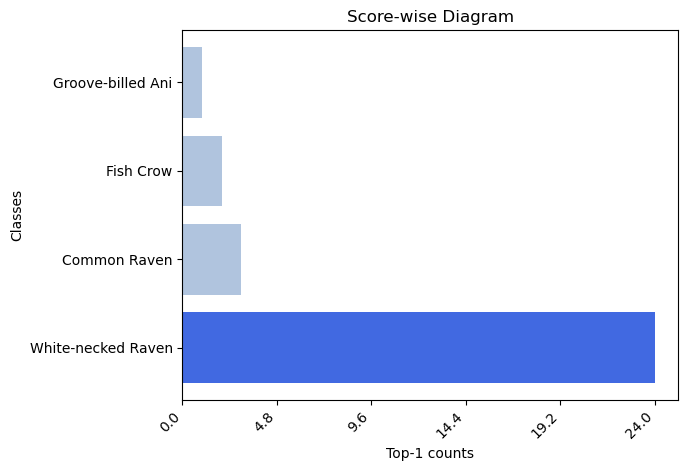

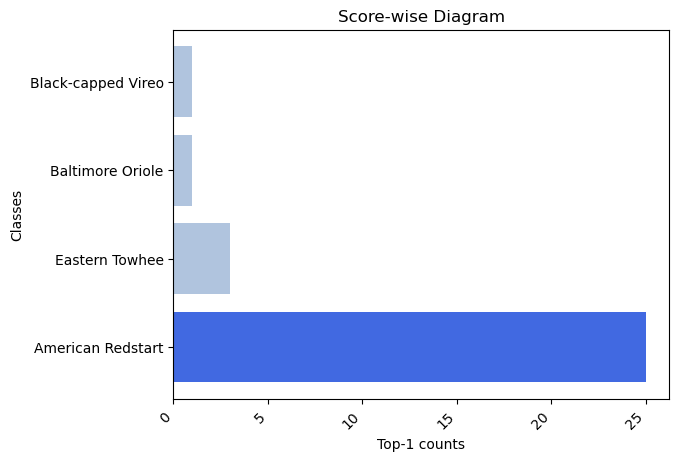

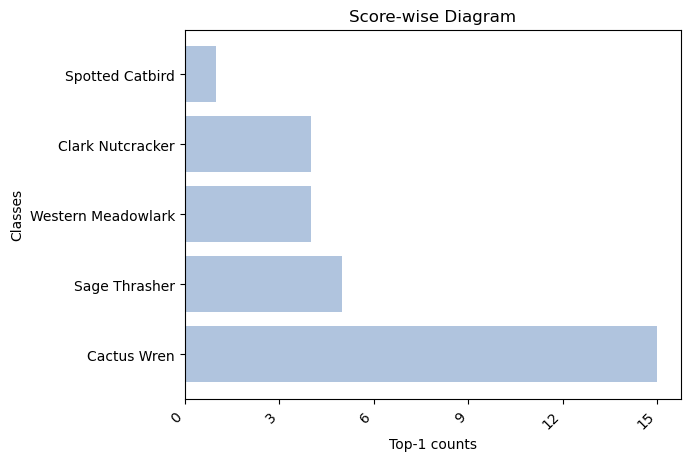

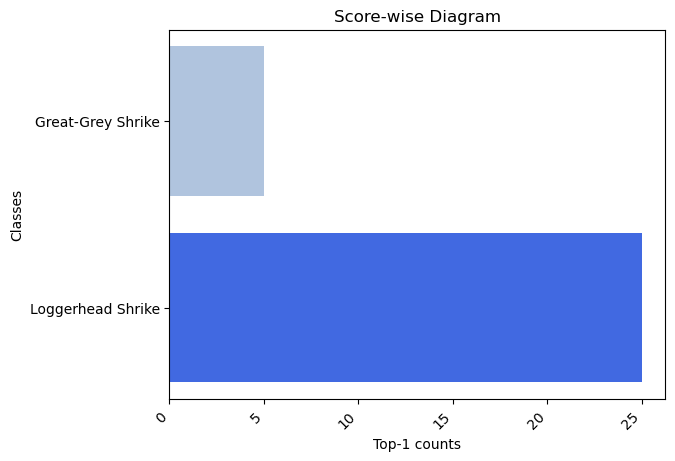

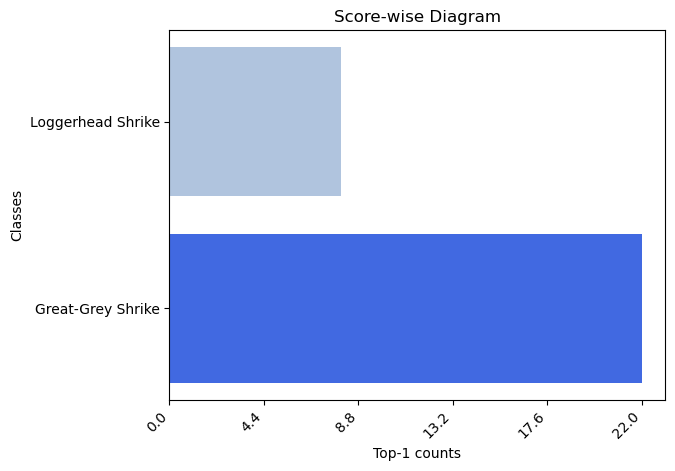

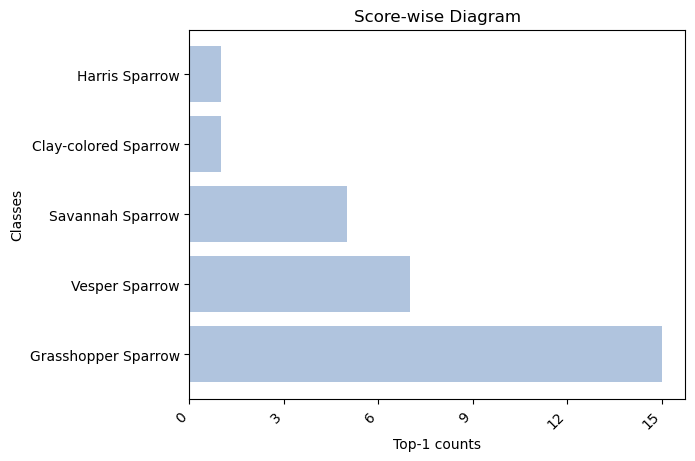

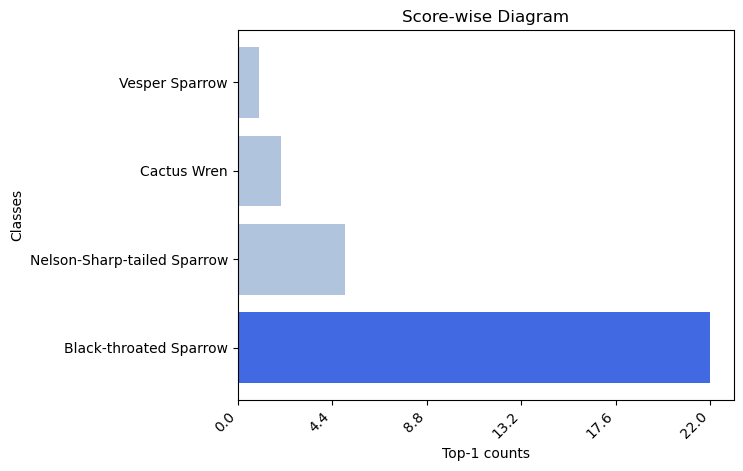

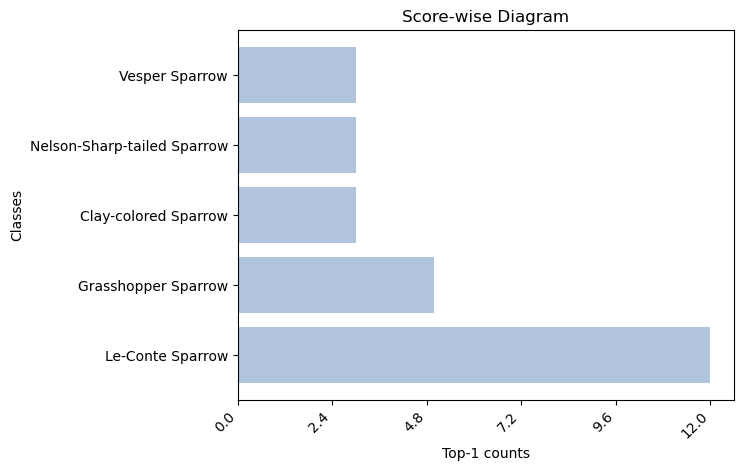

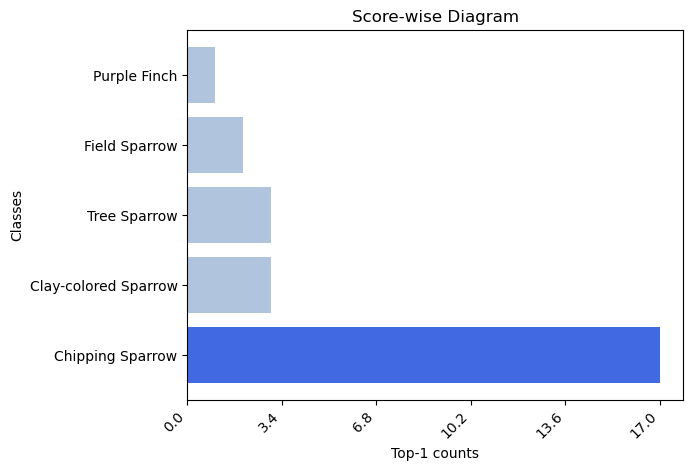

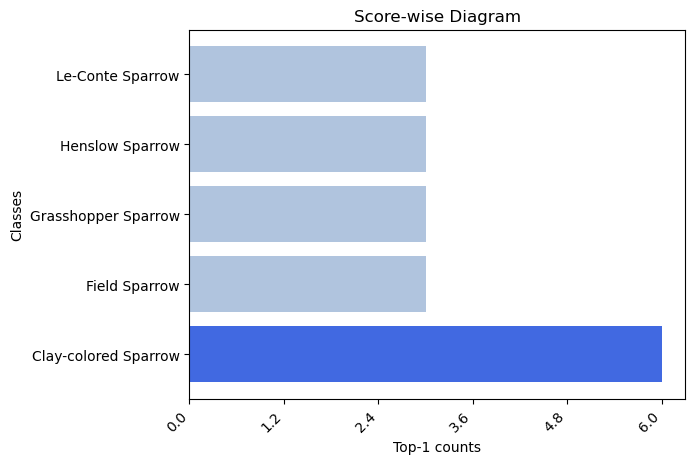

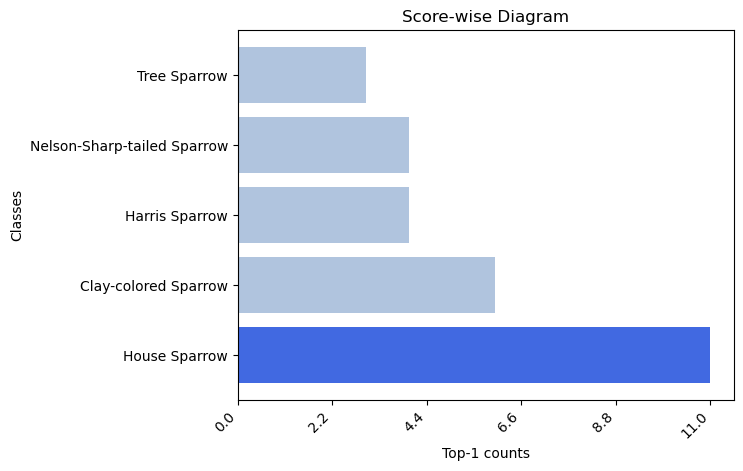

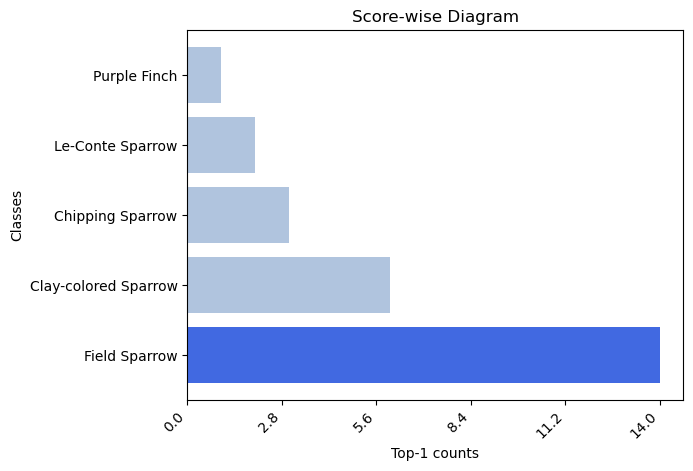

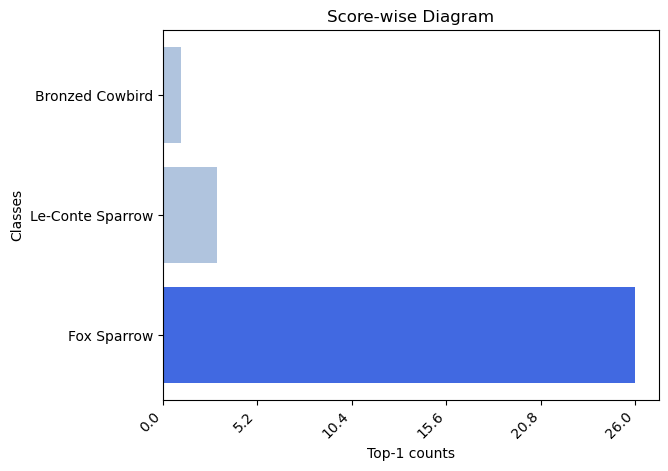

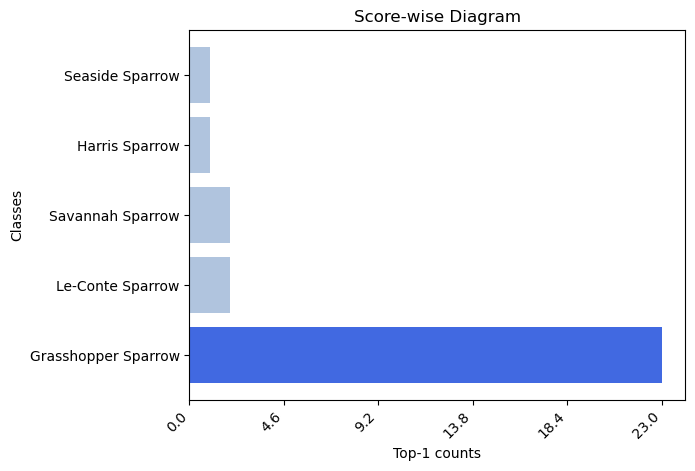

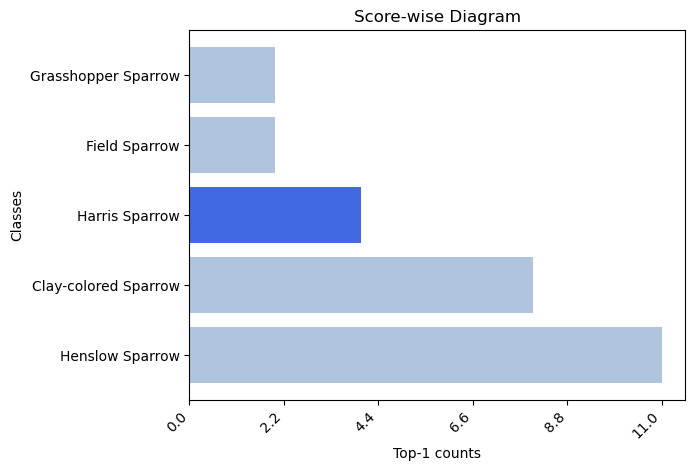

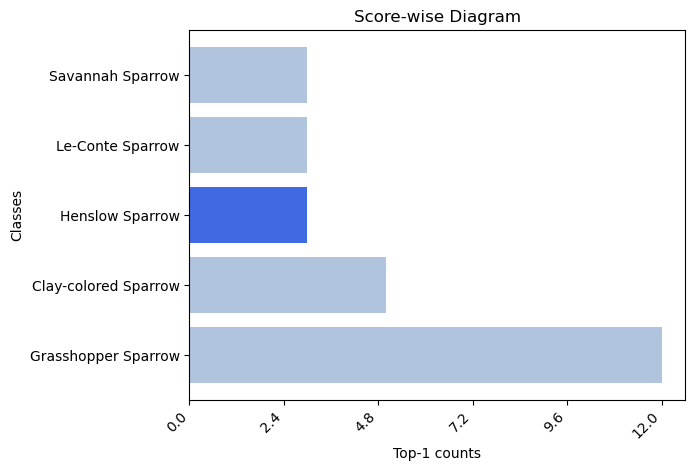

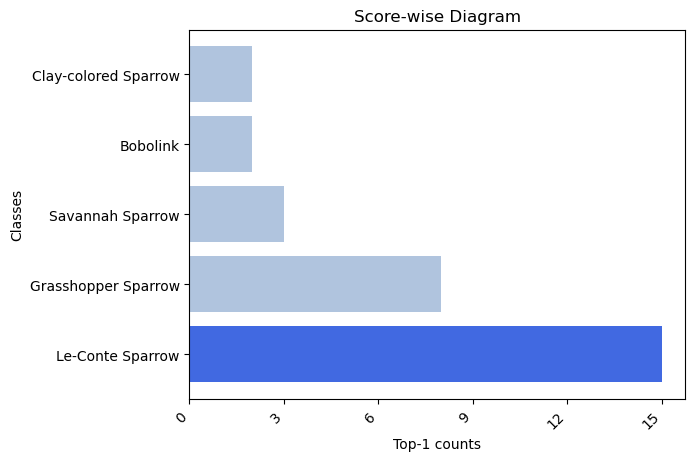

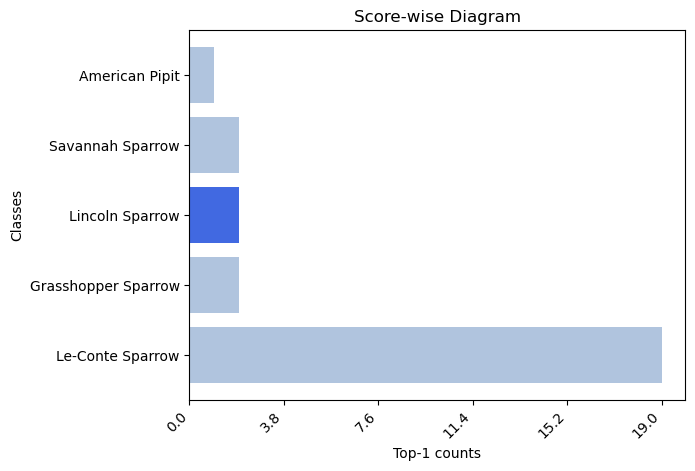

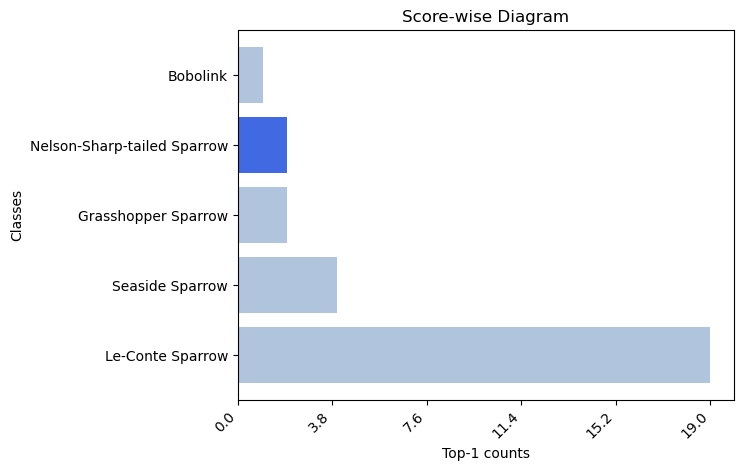

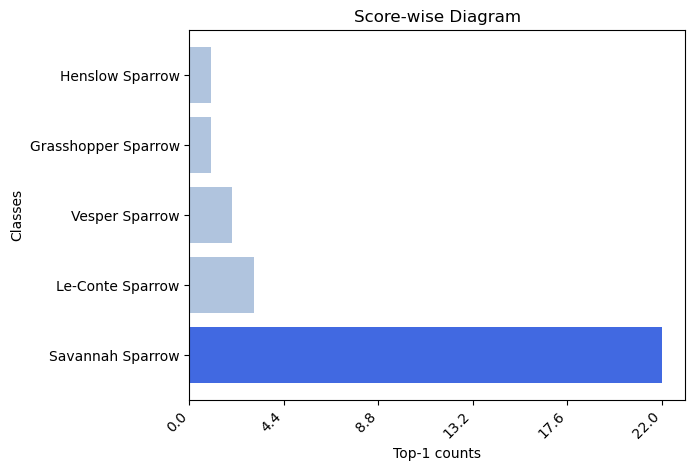

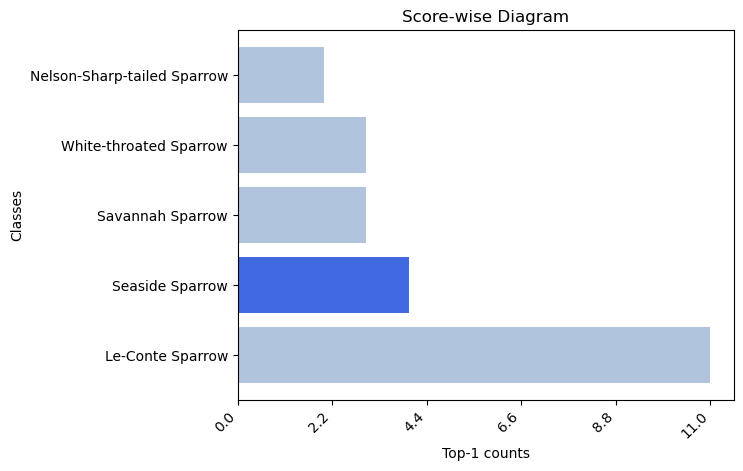

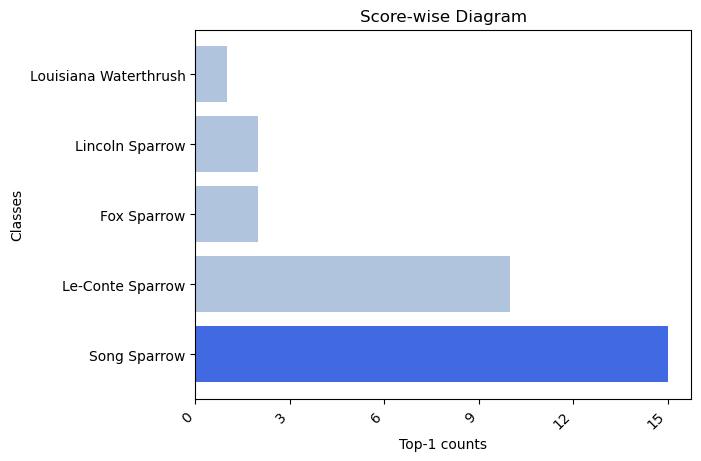

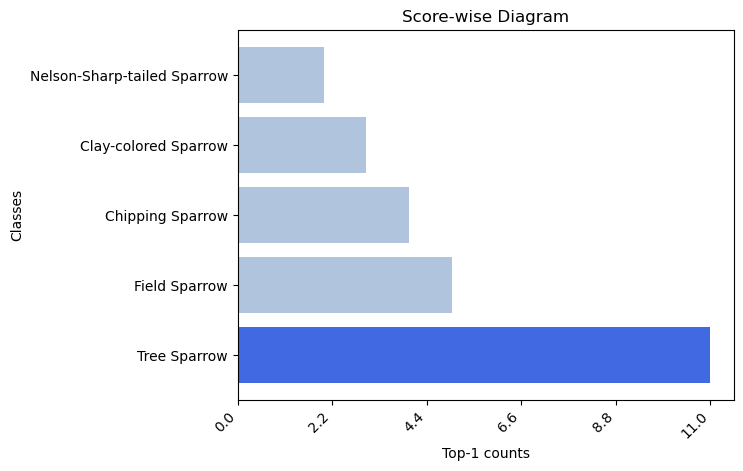

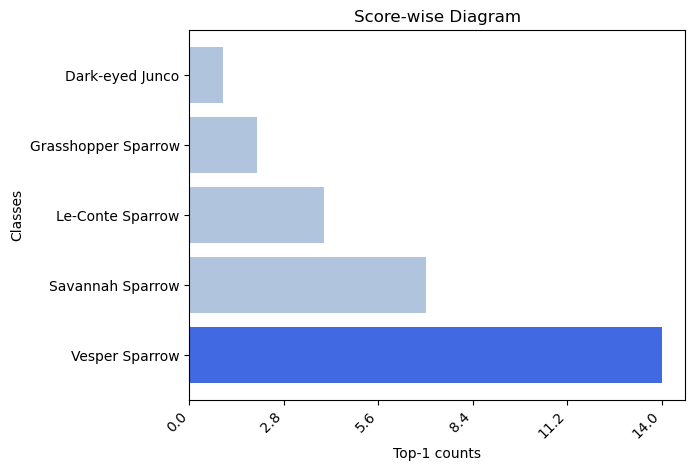

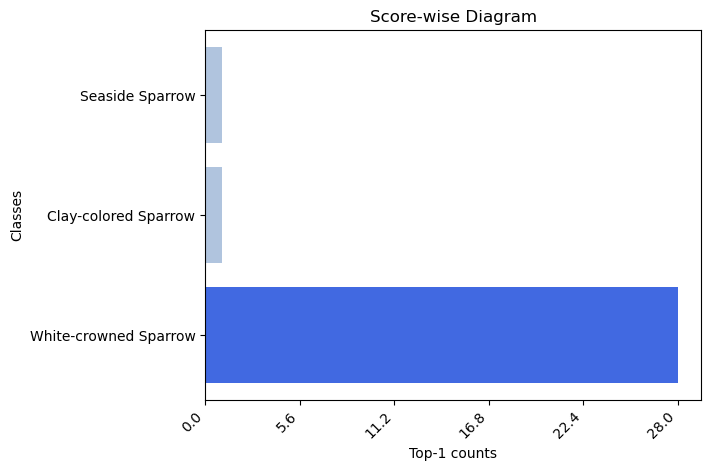

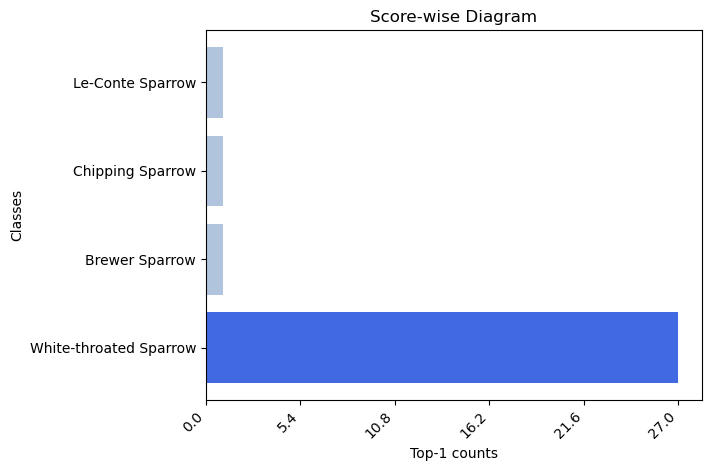

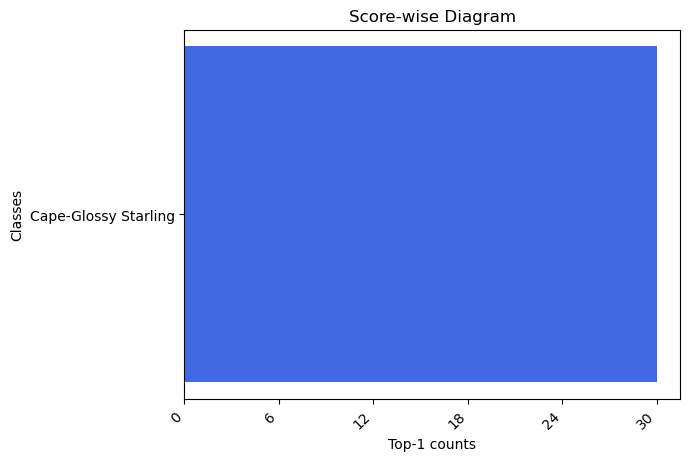

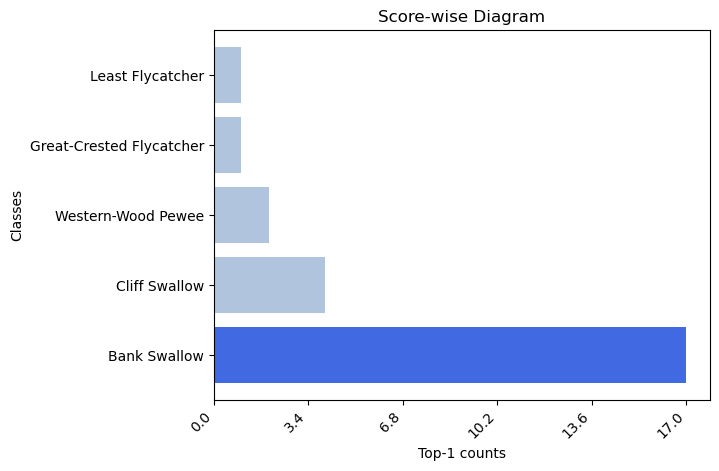

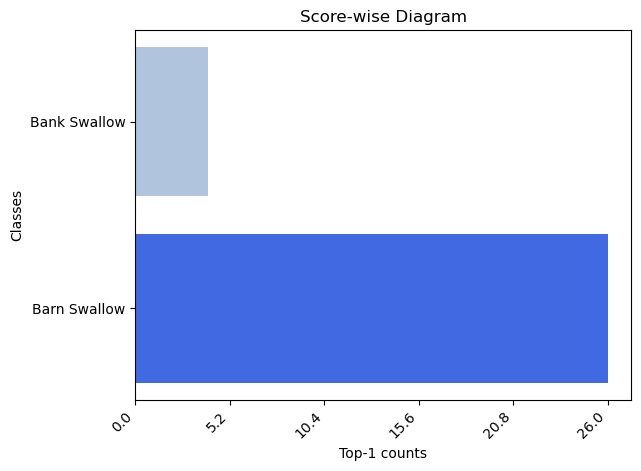

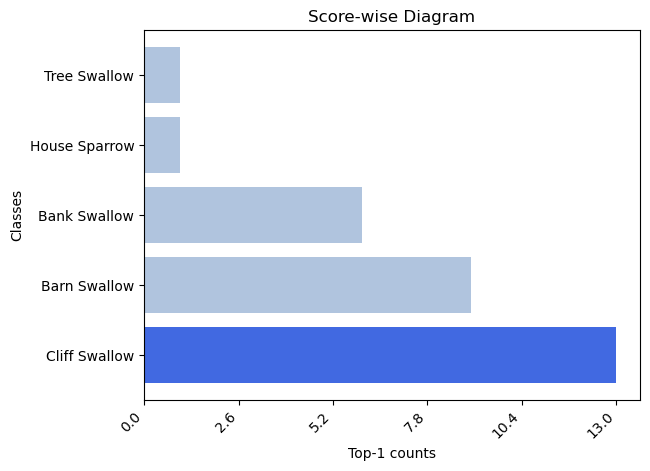

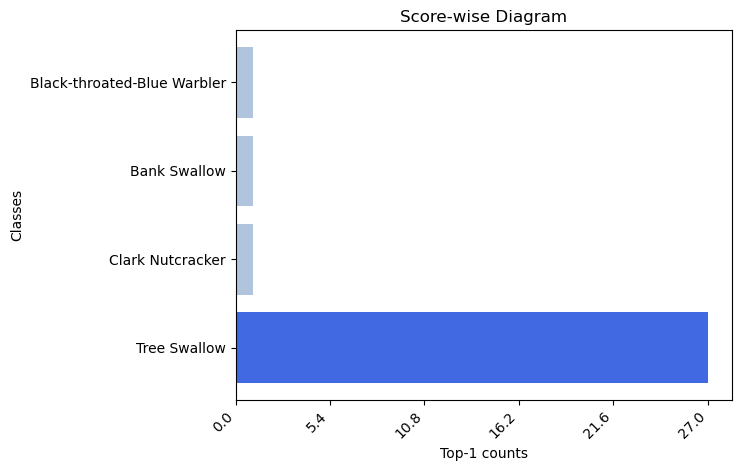

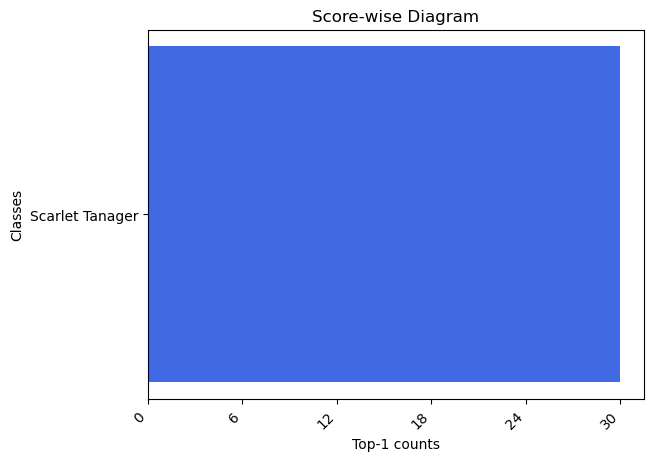

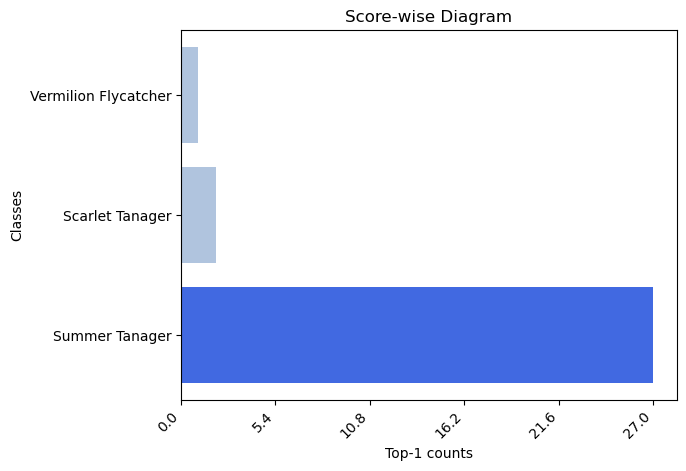

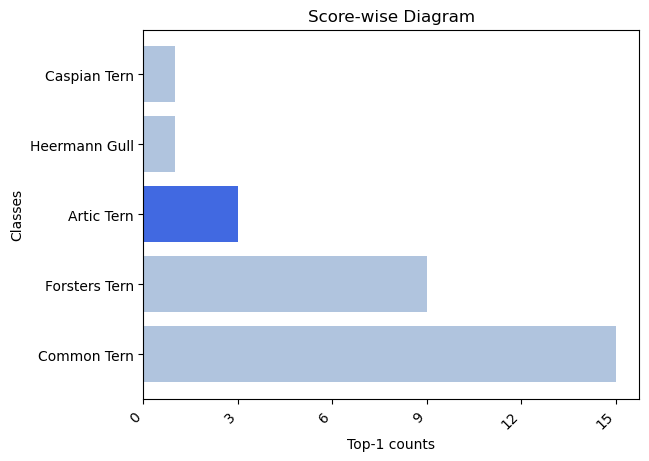

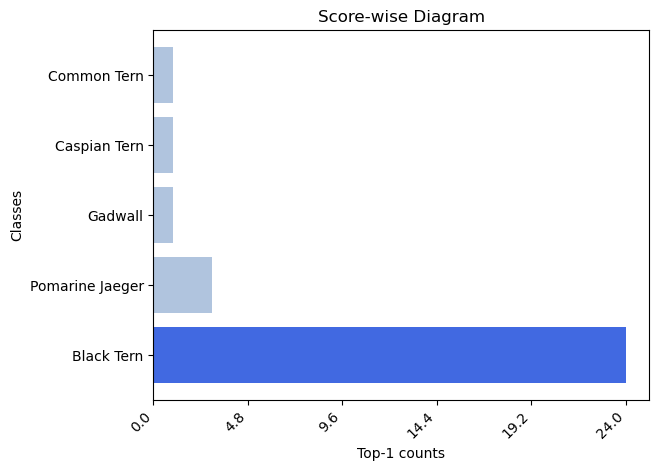

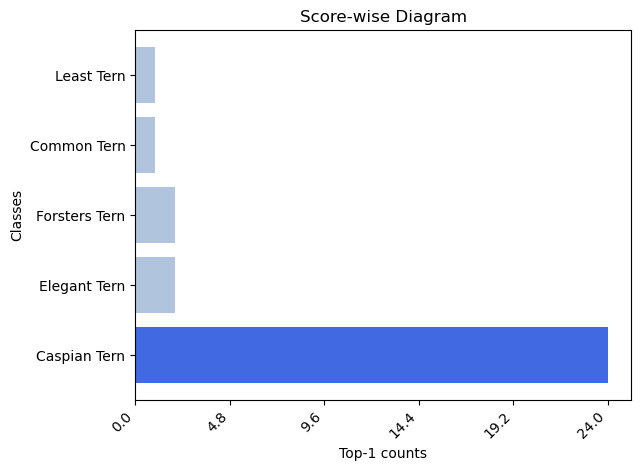

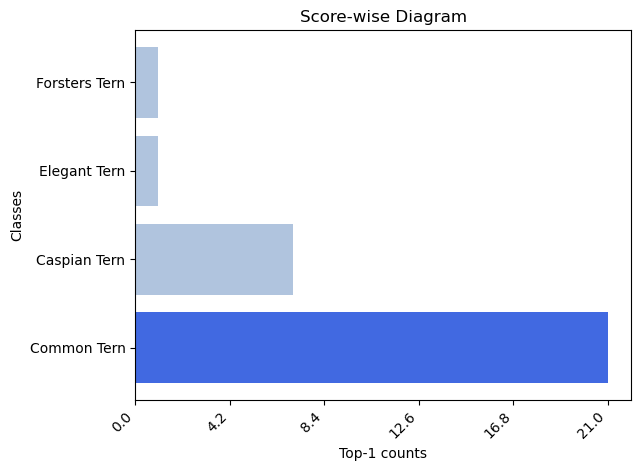

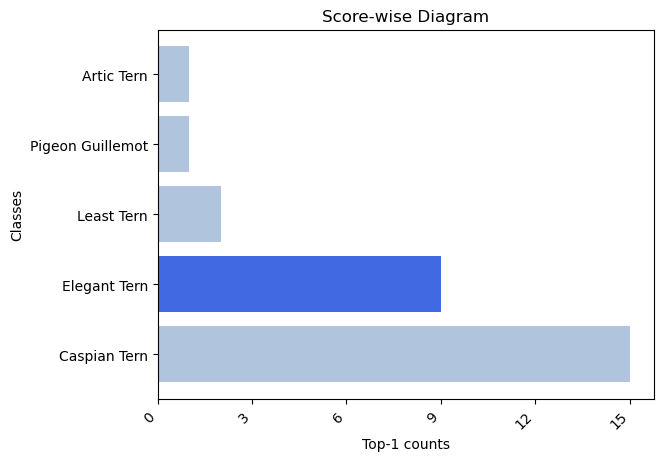

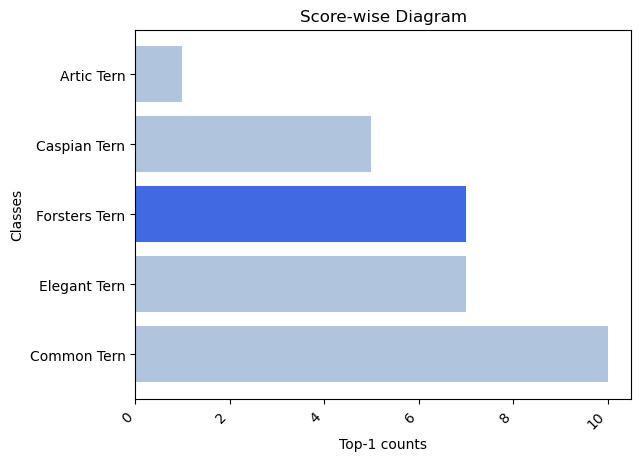

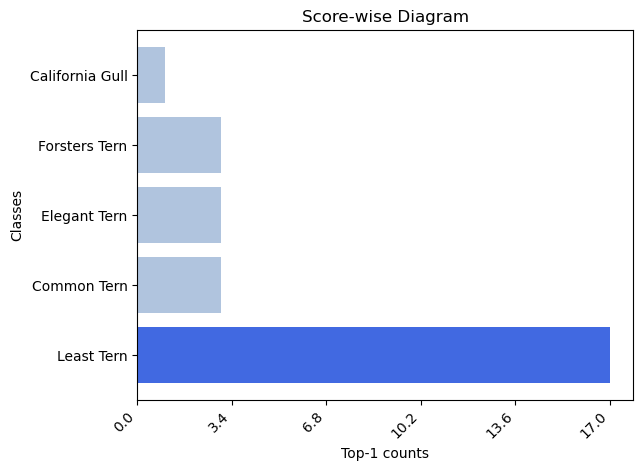

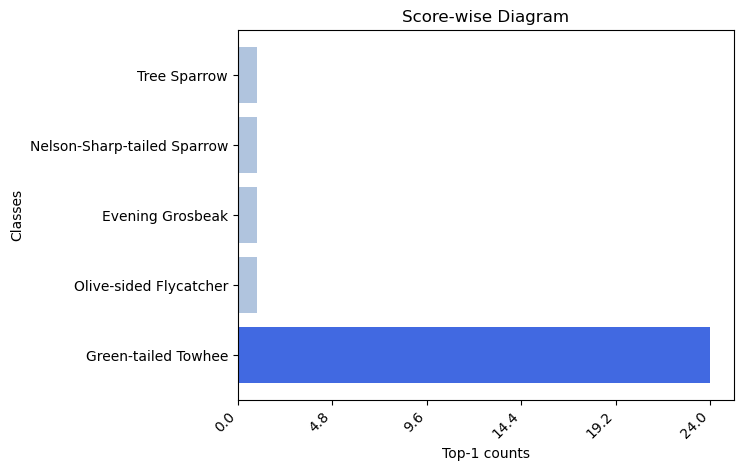

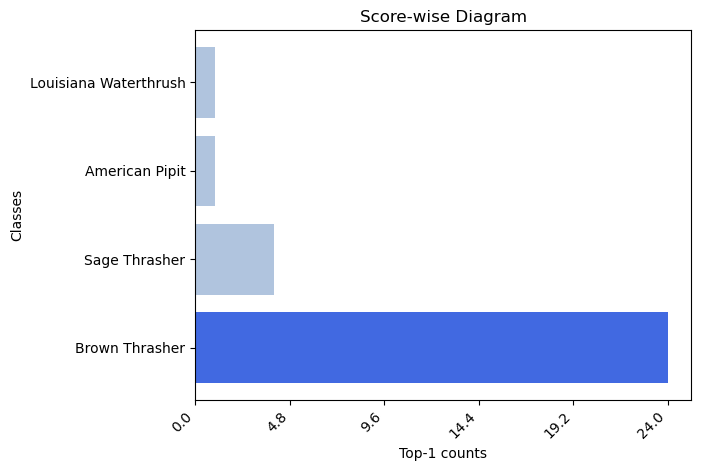

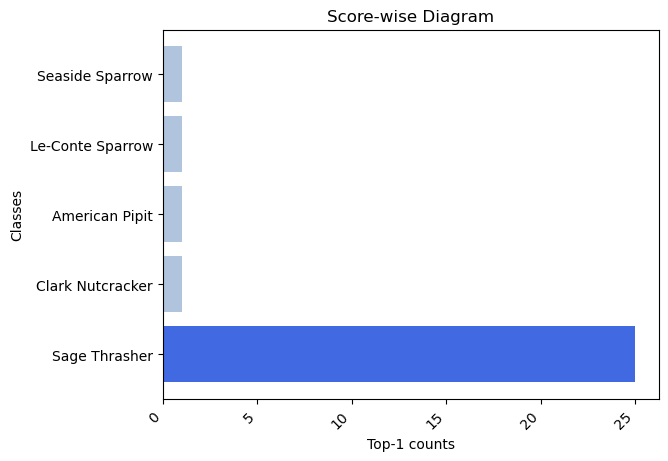

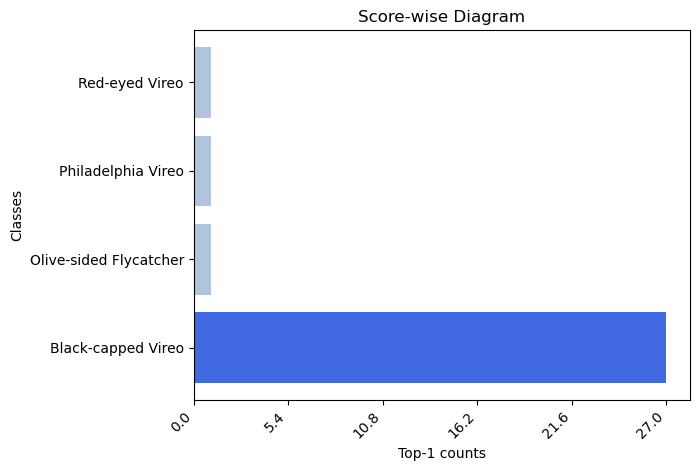

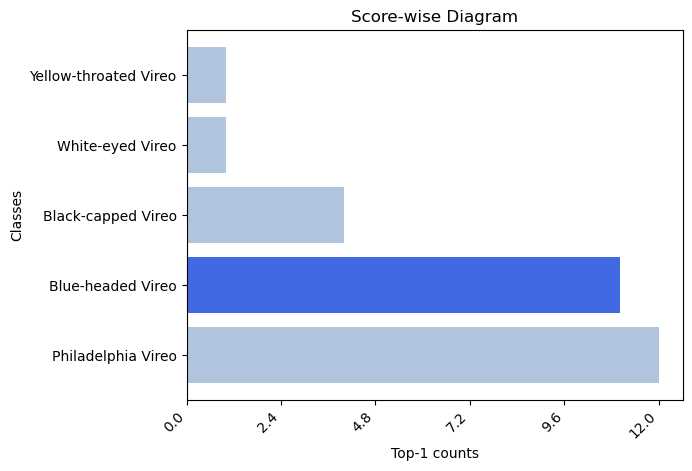

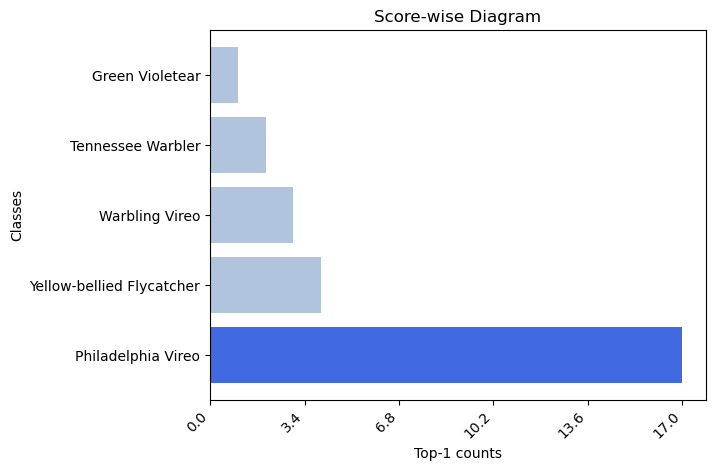

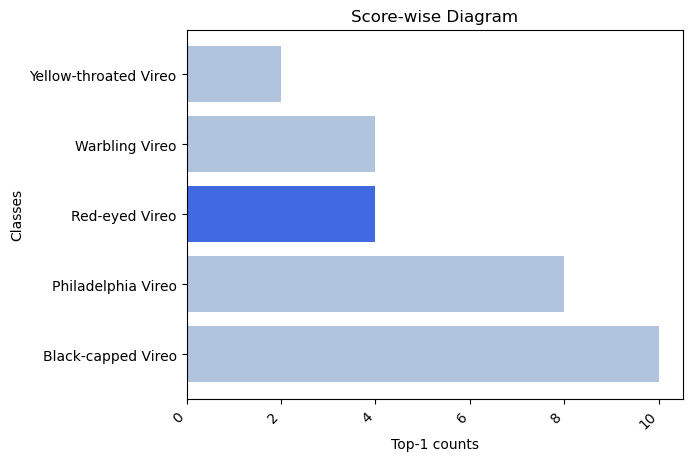

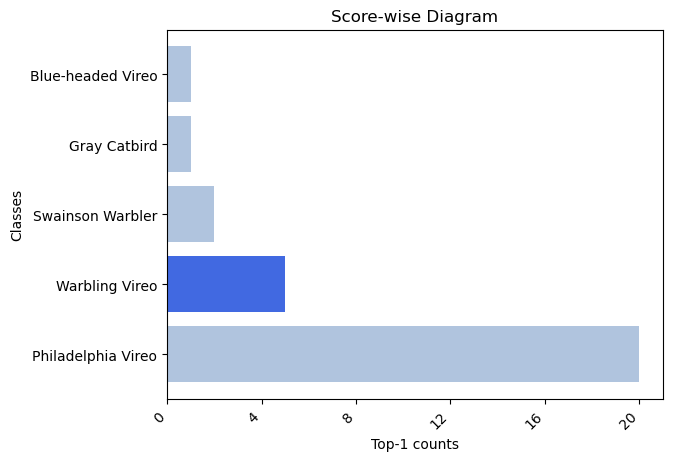

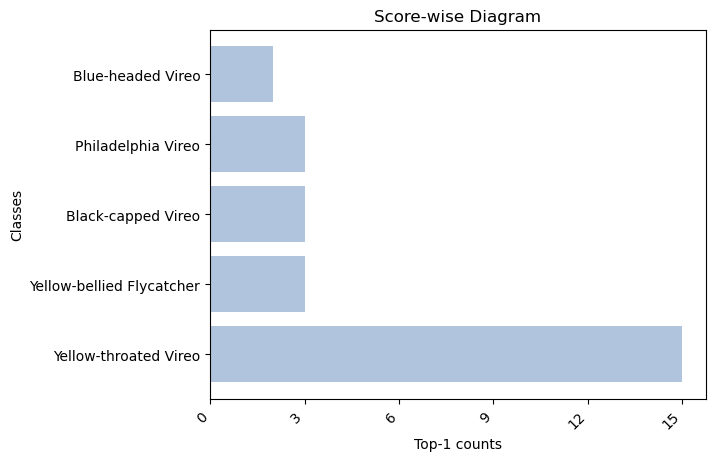

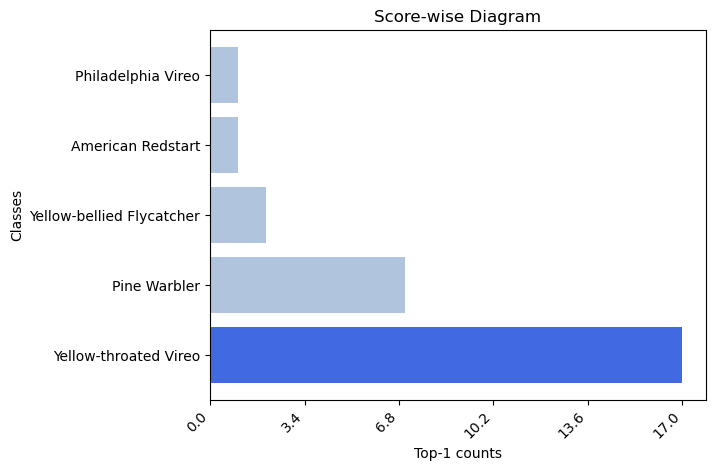

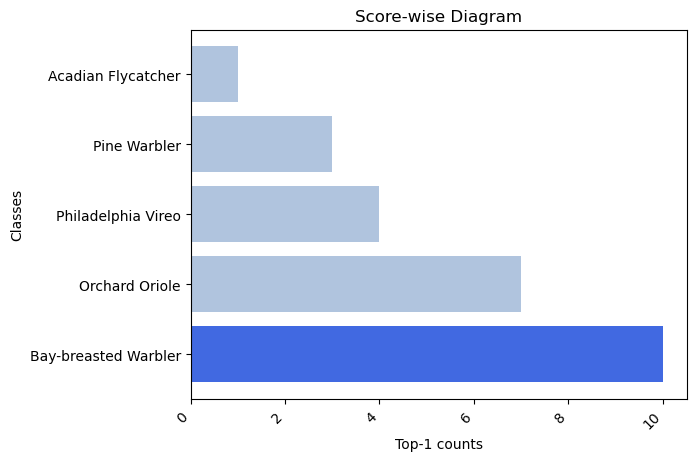

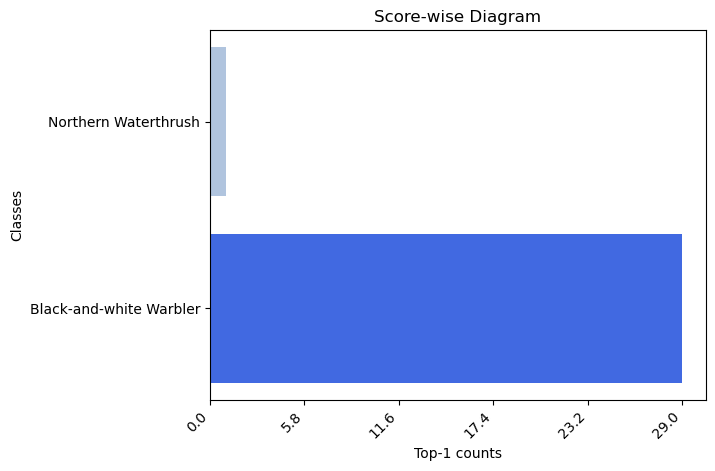

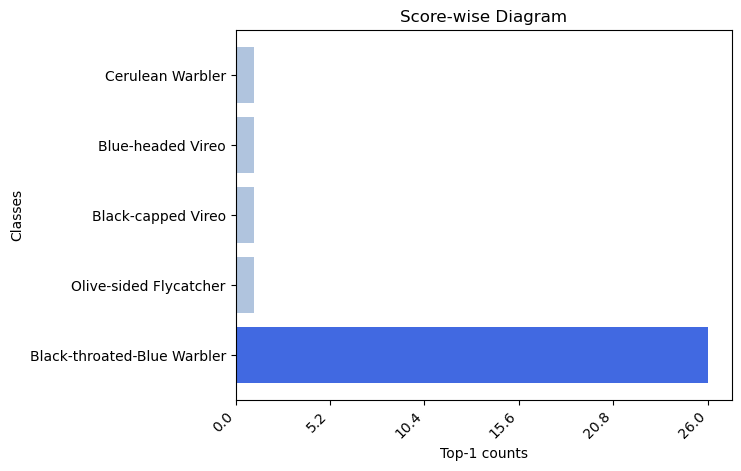

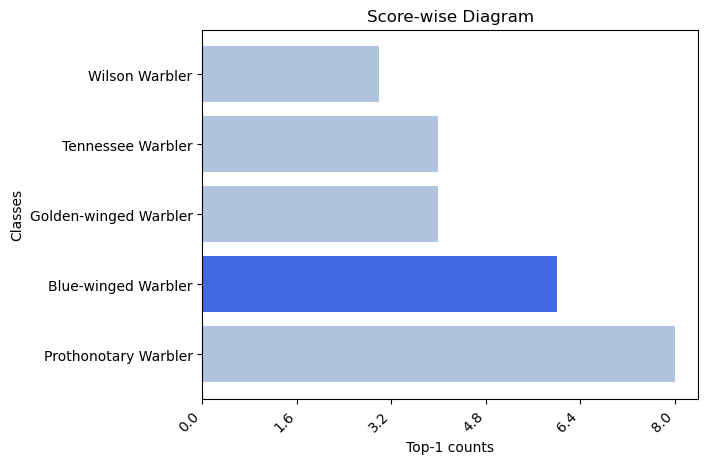

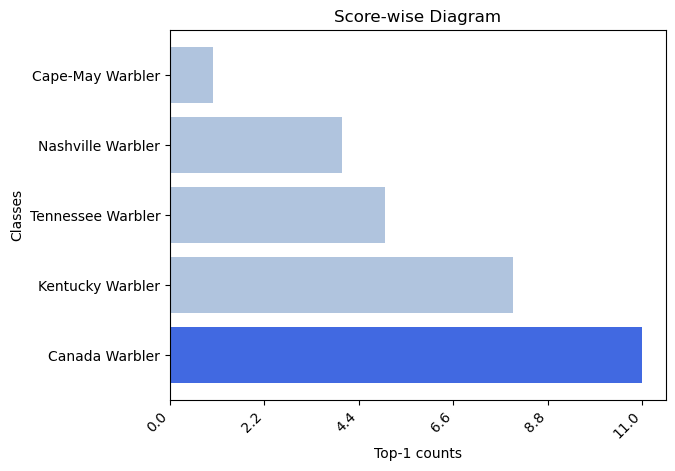

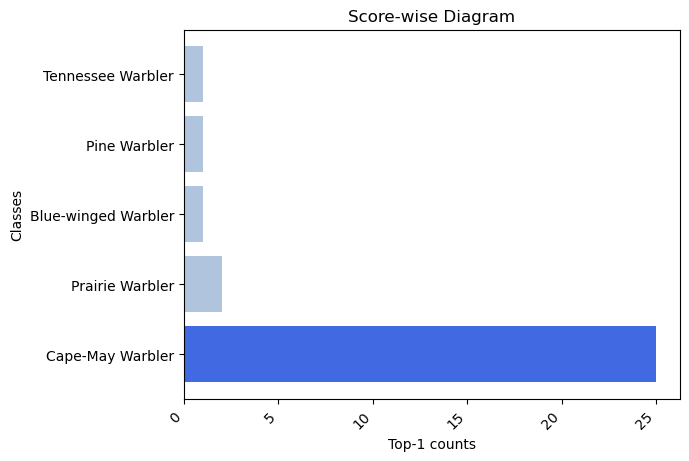

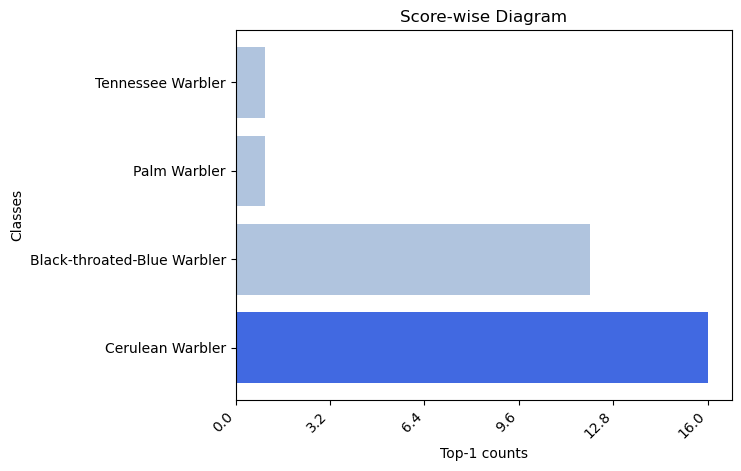

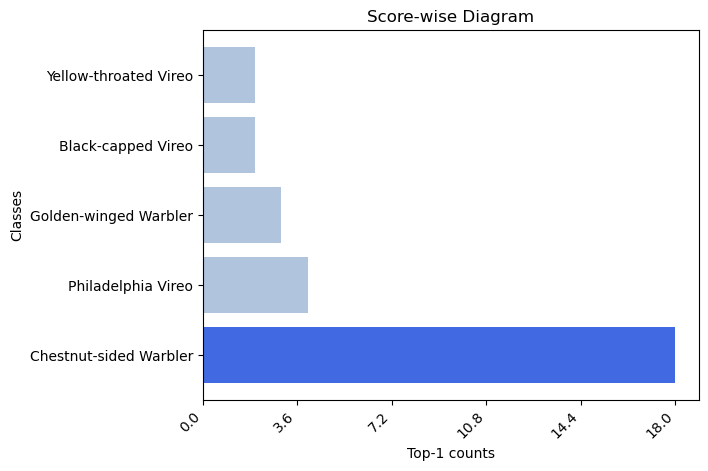

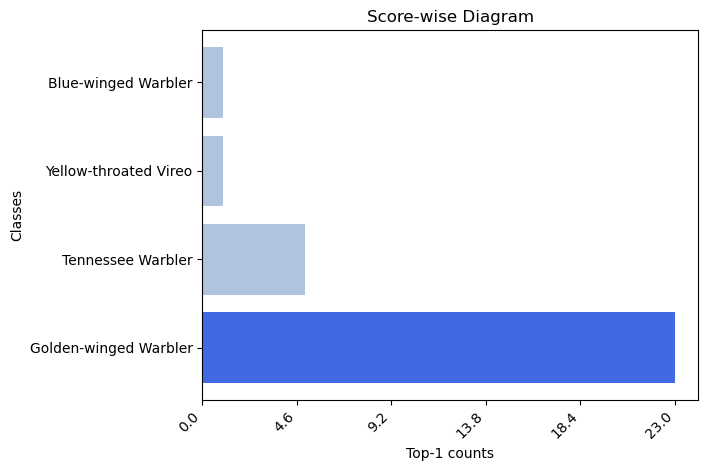

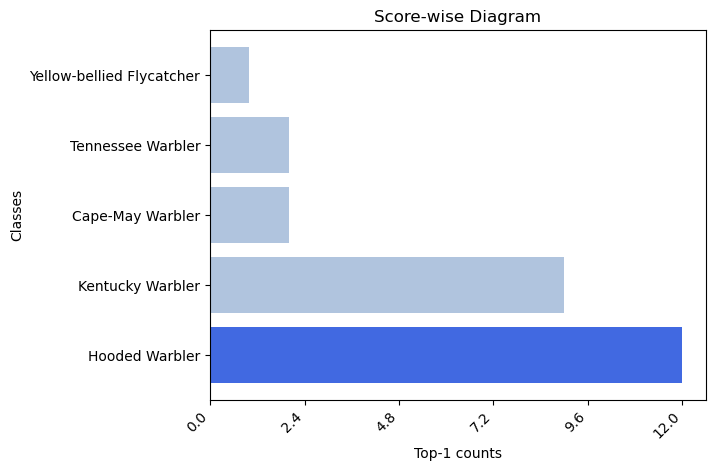

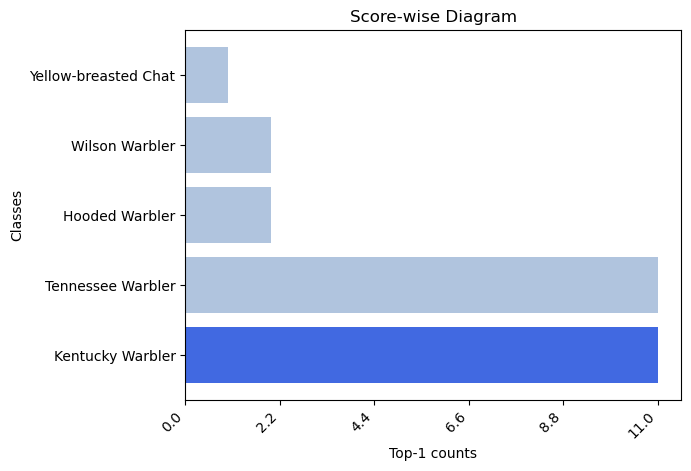

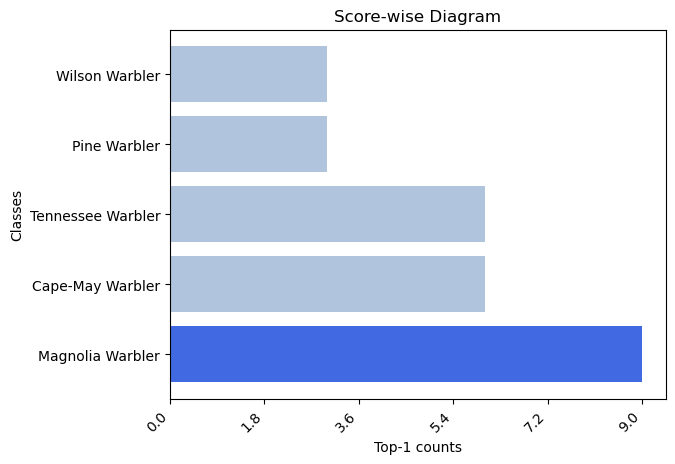

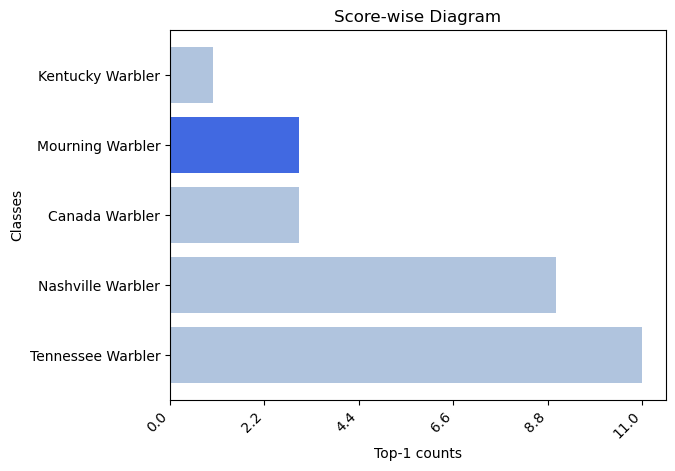

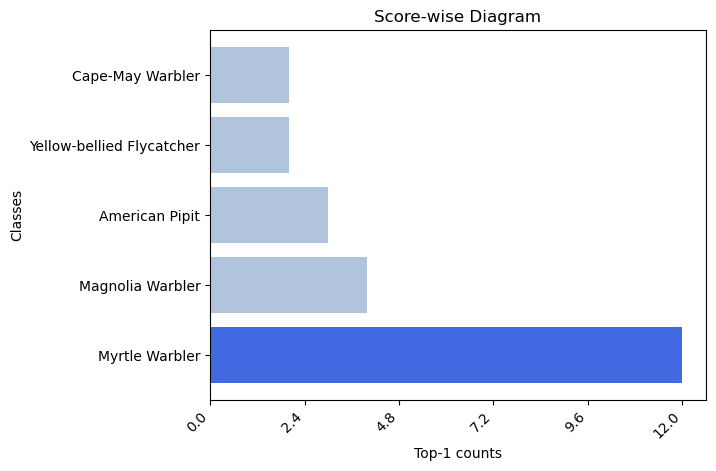

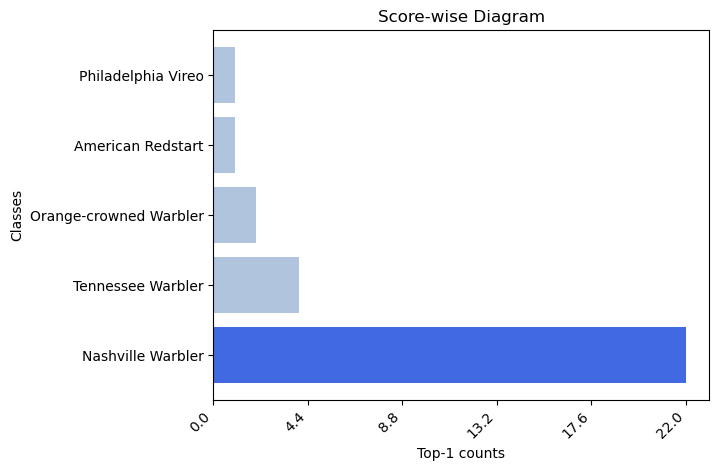

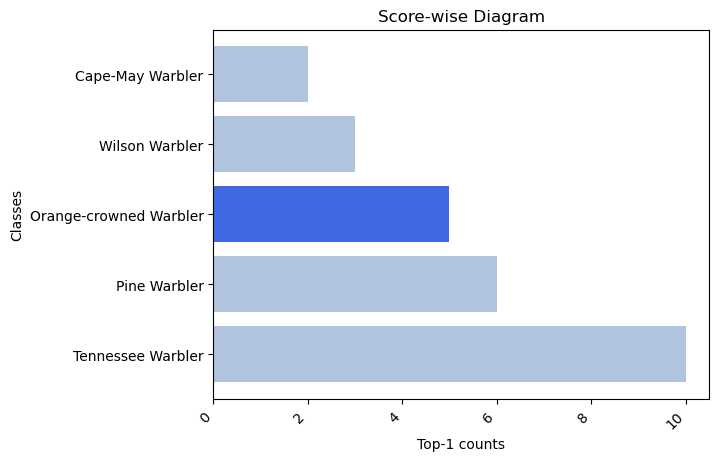

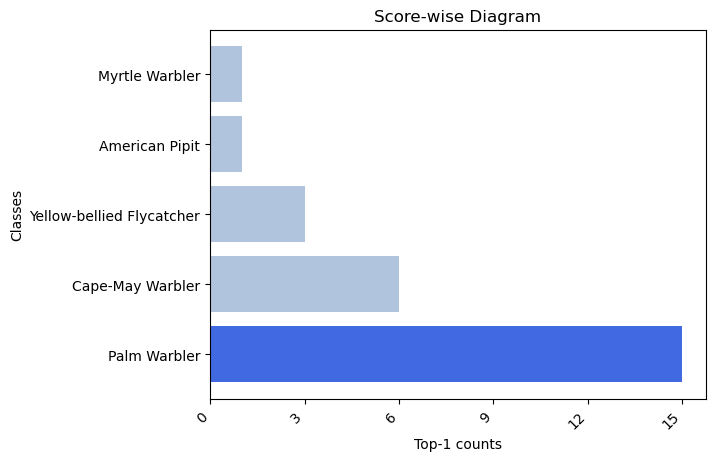

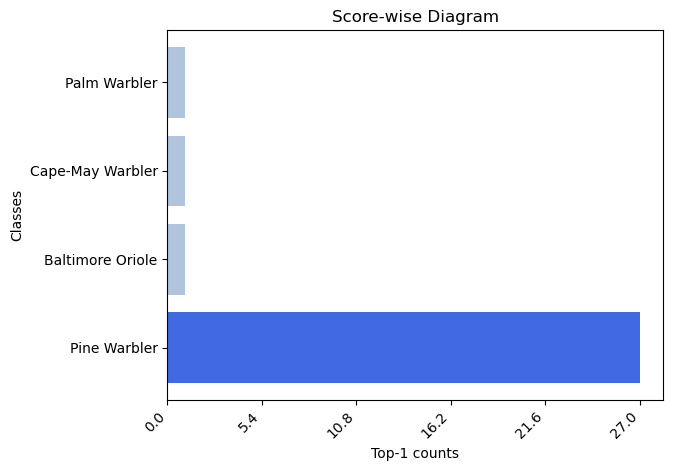

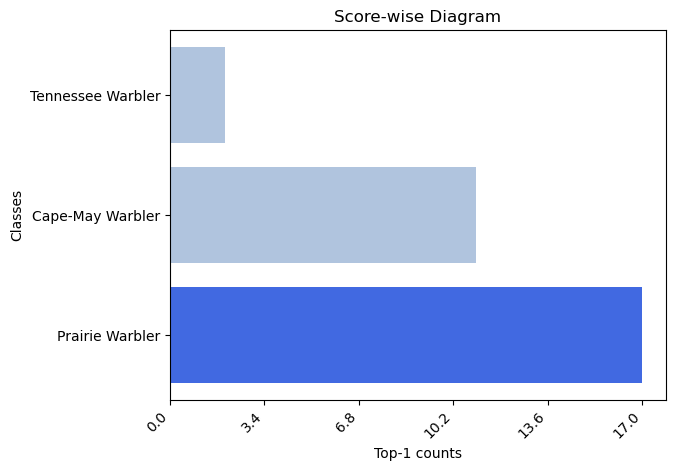

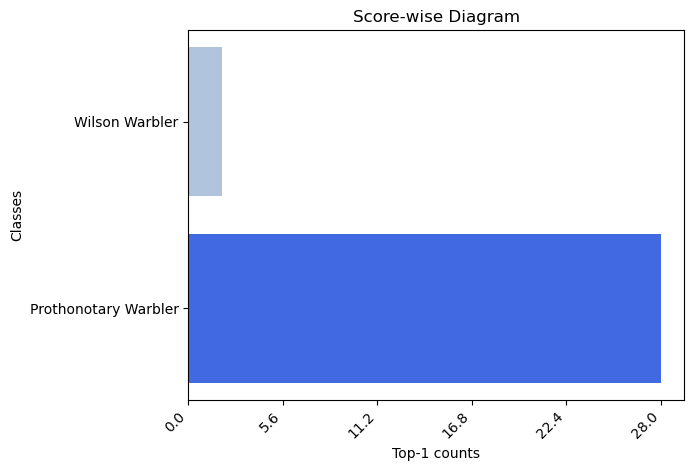

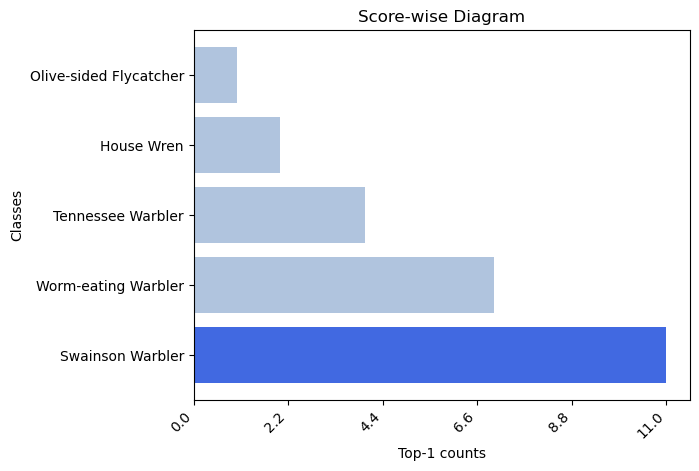

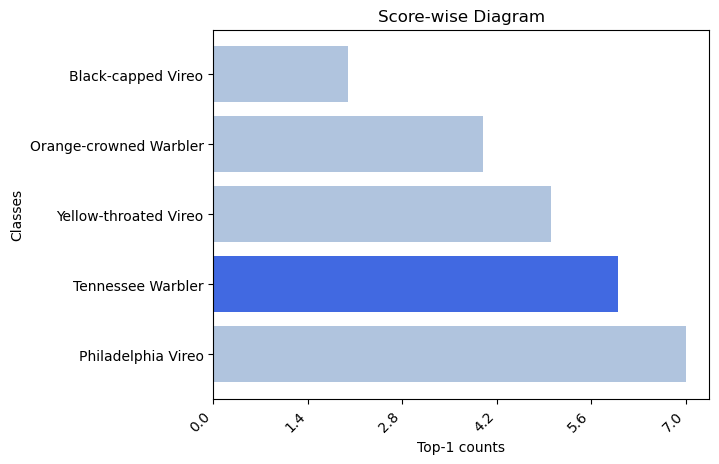

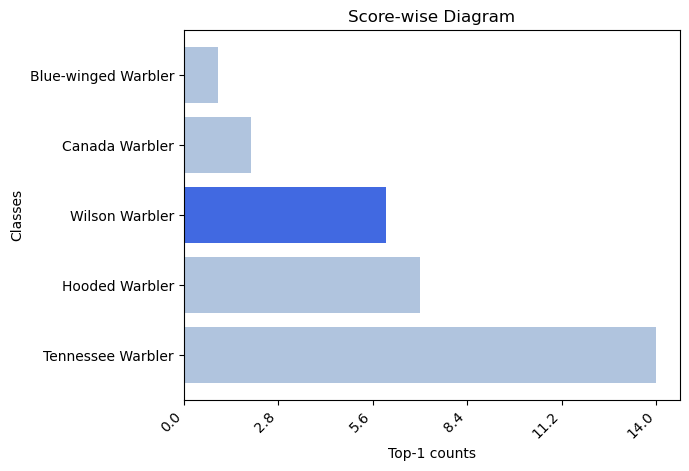

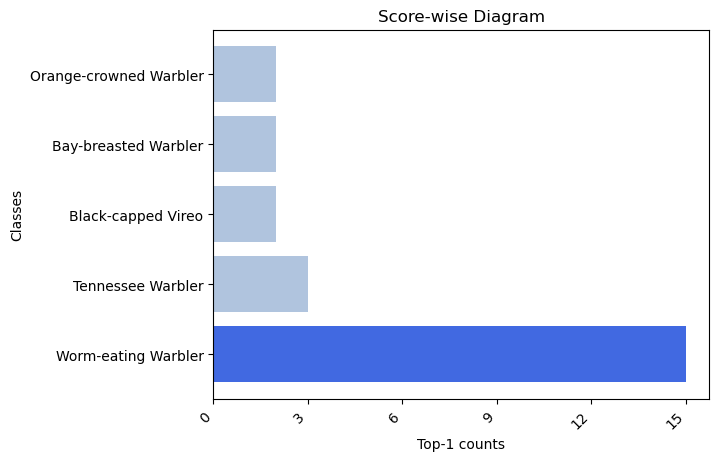

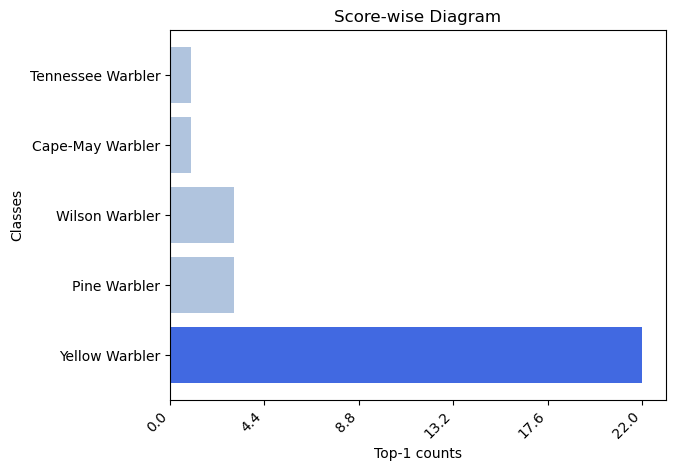

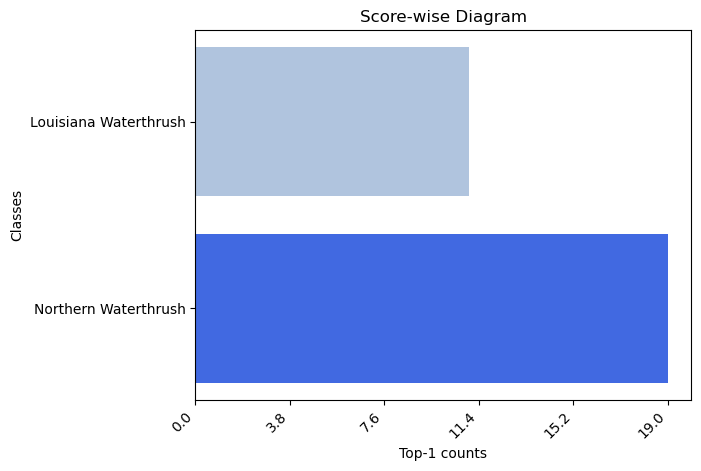

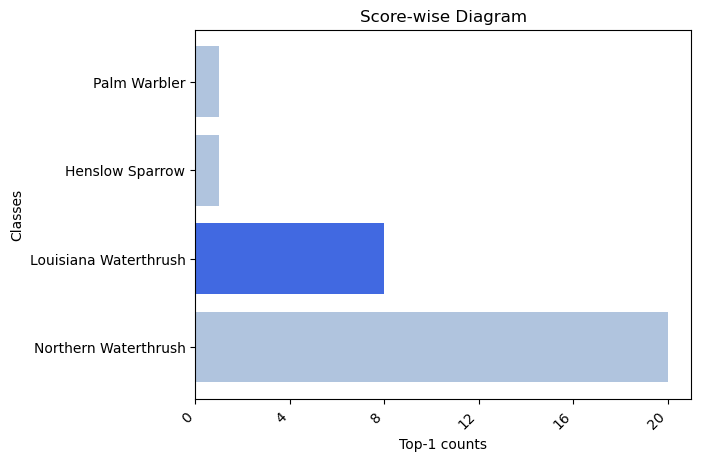

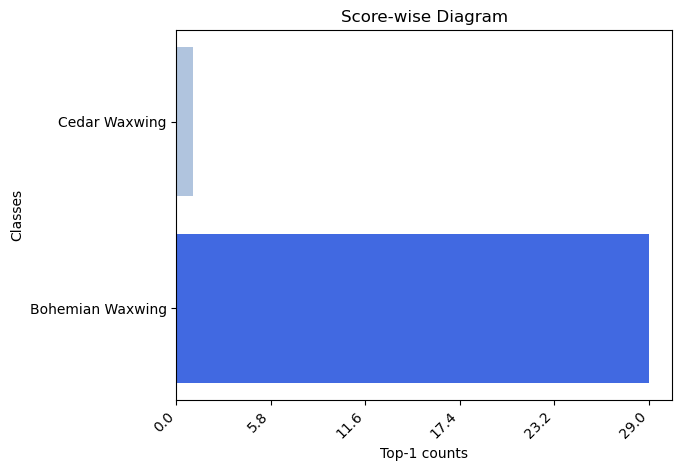

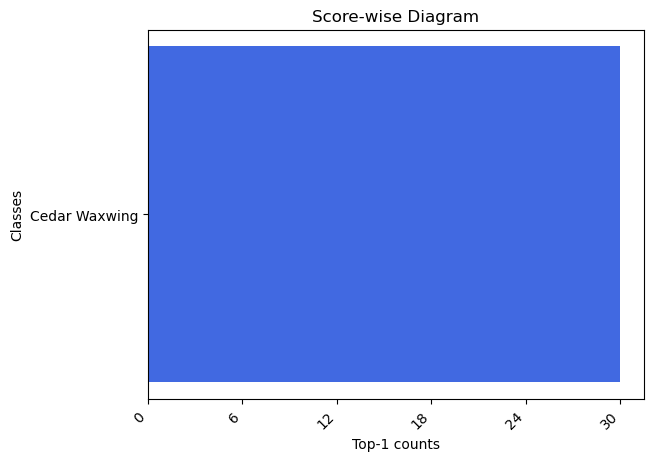

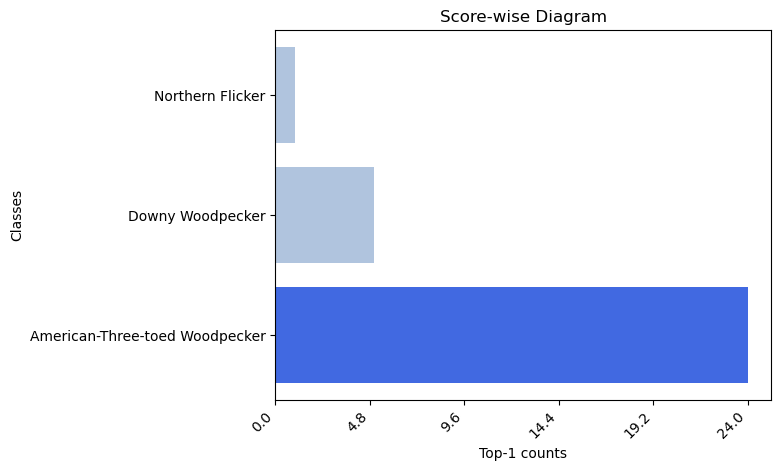

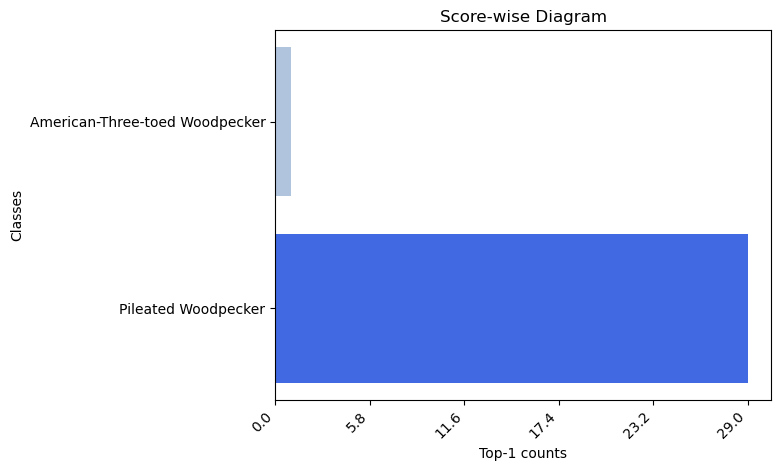

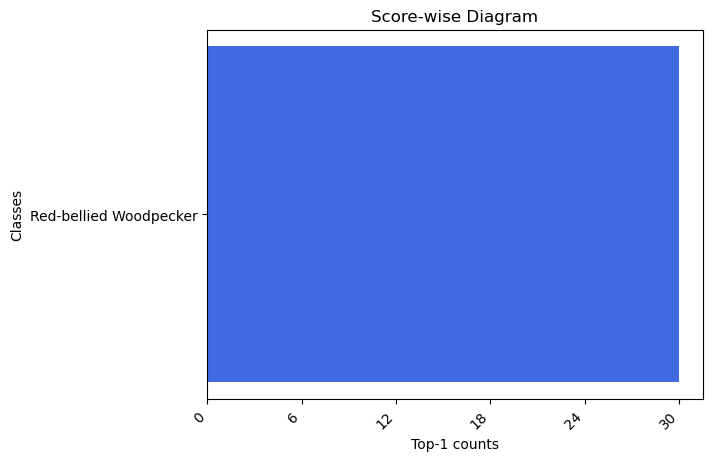

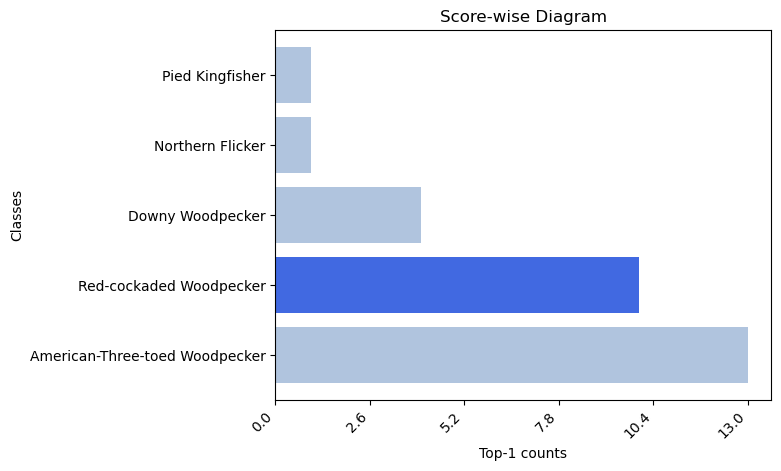

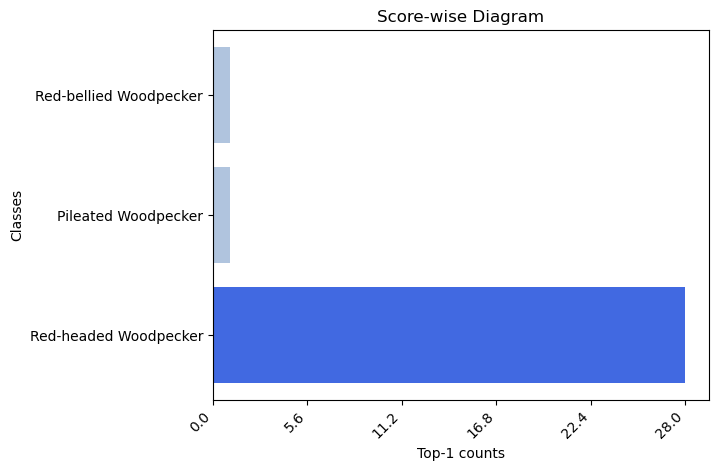

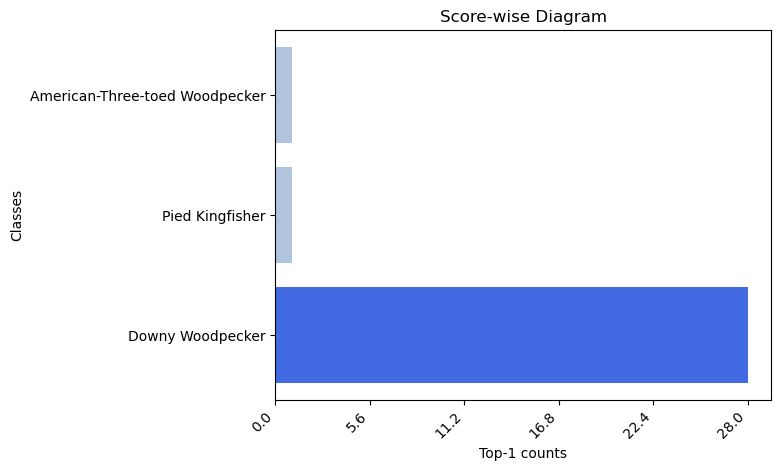

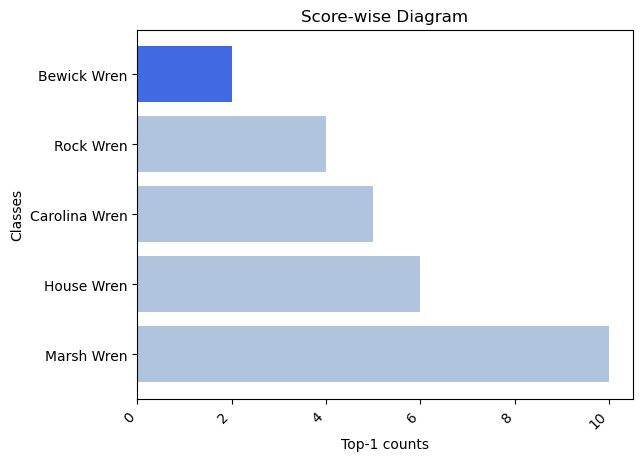

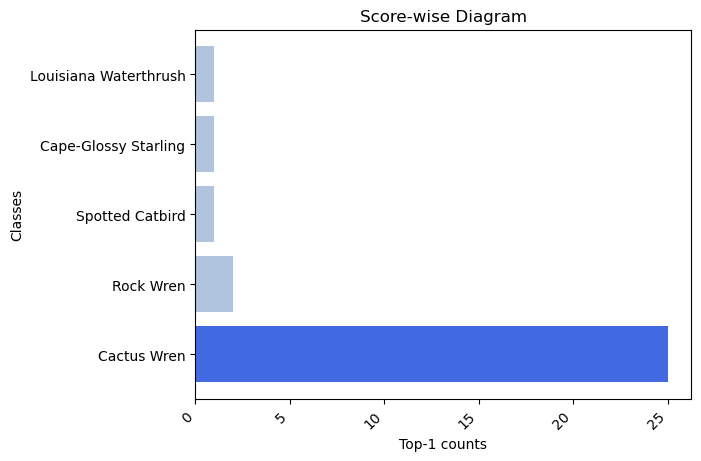

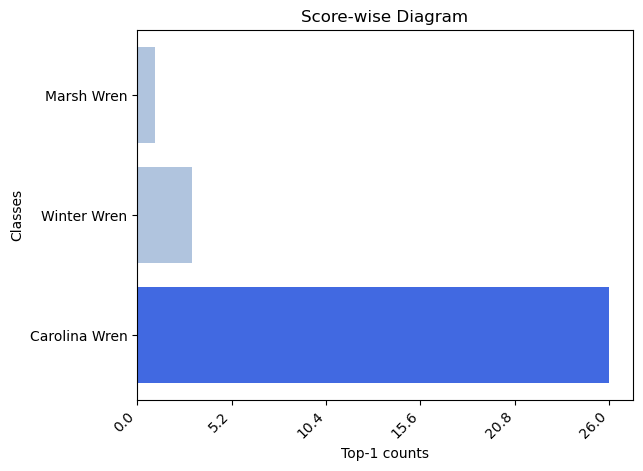

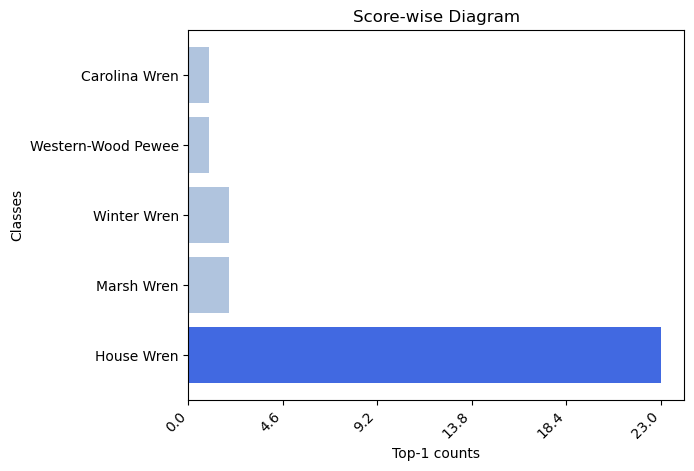

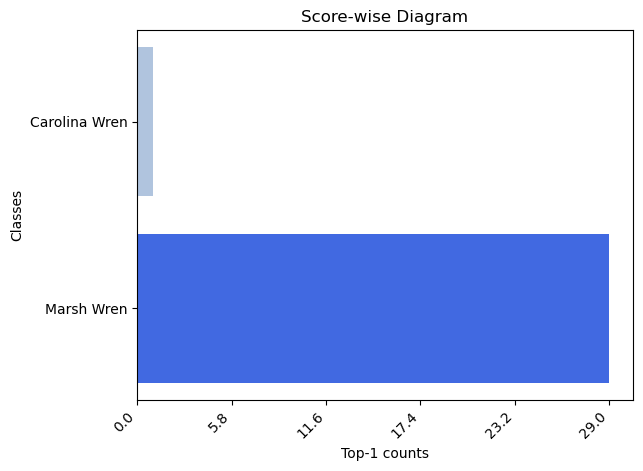

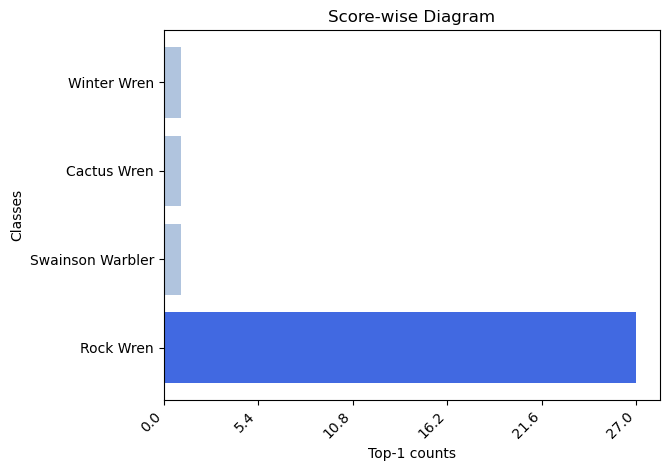

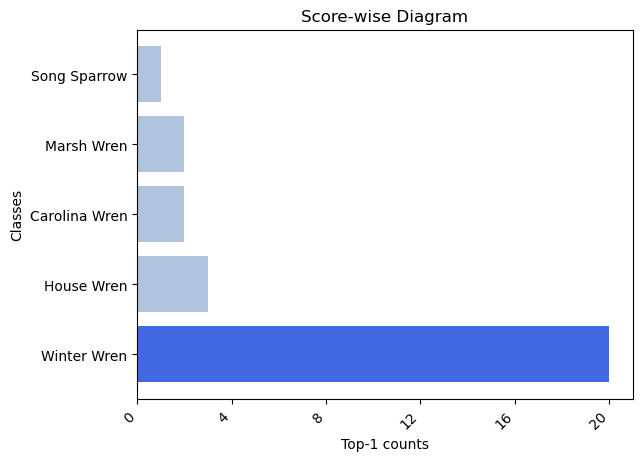

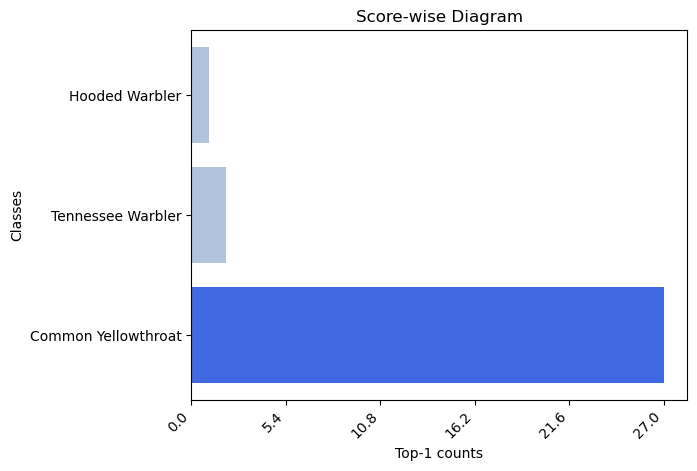

In [32]:
with open('top1_cub.json', 'r') as file:
    top = json.load(file)

for class_ in top.keys():
    greater_than_zero = []
    for top_item in top[class_]:
        if top_item[1] > 0:
            greater_than_zero.append(top_item)
    top[class_] = greater_than_zero
    create_graph(class_, top[class_][:min(len(greater_than_zero), 5)])

In [34]:
top[class_][0:5]

# [['Common Yellowthroat', 27],
#  ['Tennessee Warbler', 2],
#  ['Hooded Warbler', 1],
#  ['Black-footed Albatross', 0],
#  ['Laysan Albatross', 0]]

[['Common Yellowthroat', 27], ['Tennessee Warbler', 2], ['Hooded Warbler', 1]]

# Generate attributes functions

In [40]:
def logs():
    logging.basicConfig(
        level=logging.DEBUG,            # Set the minimum log level to DEBUG
        filename='gpt_3_my_cub.log',        # Specify the log file name
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )

    logger = logging.getLogger(__name__)
    return logger


In [45]:
def get_completion(prompt, logger, model="gpt-3.5-turbo", temperature=0., max_tokens=300):
    messages = [{'role':'system', 'content':"""
    Use this as an example to generate you answers for user's query. Give the answer in a JSON format just like given in the example

    ```Q: What are useful visual features for distinguishing a tiger from a lion in a photo?
       A: There are several useful visual features to tell the difference between a tiger and a lion in a photo:-


        {
            "tiger": [
                     "has orange coats with vertical 'black' stripes",
                     "are generally larger and robust",
                     "often have a more rounded face with prominent cheekbones",
                     "ears are usually smaller and rounded",
                     "tails are long and have a characteristic 'white spot' at the tip",
                     "are found in a variety of habitats, including dense forests and grasslands"
                     ],

            "lion": [
                    "typically have a tawny or 'beige coat', and their fur is often smoother and they have a mane",
                    "has a more compact and muscular build",
                    "lions may have a more squared-off face",
                    "ears are large and often have a more pointed shape",
                    "tails are shorter, ending in a tuft of hair",
                    "habitats are savannas and open woodlands"
                    ]
        }
        ```
    Remember not to use the first class name in the response of second class and vice-a-versa. For example here, in the answer for tiger do not use lion and in answer for lion do not use the word tiger.
"""},
    {"role": "user", "content": prompt}]
    
    try:
        logger.debug(f'Input: {messages}')
        response = openai.ChatCompletion.create(
            model=model,
            messages=messages,
            temperature=temperature,
            max_tokens=max_tokens
        )
        logger.debug(f'Output: {response}')
    except Exception as e:
        logger.error(f'error: {str(e)}')
        raise e
    return response.choices[0].message["content"]

# Create Attributes of Pairs from Top-1 Distribution

In [46]:
def generate_attributes(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
    print(prompt)
    response = get_completion(prompt, logger)
#     response = get_completion_dummy(prompt)
    answer = response
    print(response)
    
    return answer

In [47]:
def generate_attributes_dummy(class1, class2):
    logger = logs()
    
    prompt = f"""
    Q: What are useful features for distinguishing a {class1} from {class2} in a photo?
    A: There are several useful visual features to tell the difference between a {class1} and a {class2} in a photo
    """
#     print(prompt)
    return """aasdasd
    asfasfasfdas
    {
    "Laysan Albatross": [
    "have a white head and neck with a dark eye patch",
    "have a black upperwing with a white trailing edge",
    "underside is mostly white with dark edges on the underwing",
    "have a pink bill with a dark tip",
    "are generally medium-sized with a wingspan of around 6 feet",
    "nest in the Northwestern Hawaiian Islands"
    ],

    "Sooty Albatross": [
        "have a dark plumage overall, including the head and neck",
        "have a uniformly dark upperwing without a distinct pattern",
        "underside is dark, often with paler edges on the underwing",
        "have a dark bill without significant markings",
        "are larger in size with a wingspan of around 7 feet",
        "nest on sub-Antarctic islands and some isolated islands in the Southern Ocean"
    ]
    }sfsdfsdfsdf"""

In [48]:
def process_response(response):
    try:
        json_response = response
        json.loads(json_response)
    except Exception as e:
        lines = response.split('\n')
        json_response = ''
        for index, line in enumerate(lines):
            if line.find('{') != -1:
                json_response = line[line.find('{'):] + "\n"
                index += 1
                while index < len(lines) and lines[index].find('}') == -1:
                    json_response += lines[index]
                    index += 1
                if index < len(lines) and lines[index].find('}') != -1:
                    json_response += lines[index][:lines[index].find('}')+1]
                    break
                else:
                    html_string = f'<font color="red">{str(response)}</font>'
                    display(HTML(html_string))
    return json.loads(json_response)

In [62]:
def convert_to_json(diff_dict):
    dict_ = diff_dict.copy()
    for key in dict_.keys():
        dict_[key] = list(dict_[key])
    return json.dumps(dict_, indent=4)

In [66]:
diff_dict = dict()
already_seen = set()
total_pairs = 0

In [65]:
import time
for class_ in tqdm(top.keys()):
    if class_ not in diff_dict:
        diff_dict[class_] = set([f"A photo of a {class_}"])
    number_of_pairs = 0
    for top_class, count in top[class_][0:6]:
        if top_class not in diff_dict:
            diff_dict[top_class] = set([f"A photo of a {top_class}"])
        if class_ == top_class or (class_, top_class) in already_seen or number_of_pairs >=5 or count < 1:
            continue
        response = generate_attributes(class_, top_class)
        try:
            json_response = process_response(response)
            keys = list(json_response.keys())
            fixed_json_response = dict()
            fixed_json_response[class_] = json_response[keys[0]]
            fixed_json_response[top_class] = json_response[keys[1]]
        except:
            print("Could not process the input, continue...")
            continue
            
        if class_ in diff_dict:
            diff_dict[class_] |= set(fixed_json_response[class_])
        if top_class in diff_dict:
            diff_dict[top_class] |= set(fixed_json_response[top_class])
            
        already_seen.add((class_, top_class))
        already_seen.add((top_class, class_))
        number_of_pairs += 1
        total_pairs += 1
        
        descriptor_json = convert_to_json(diff_dict)
        with open(f'descriptors_cub.json', 'w') as file:
            file.write(descriptor_json)
    

  0%|                                                   | 0/200 [00:00<?, ?it/s]


    Q: What are useful features for distinguishing a Sooty Albatross from Pomarine Jaeger in a photo?
    A: There are several useful visual features to tell the difference between a Sooty Albatross and a Pomarine Jaeger in a photo
    


  2%|▋                                          | 3/200 [00:09<10:18,  3.14s/it]

{
    "Sooty Albatross": [
        "has a dark brown or blackish plumage",
        "has a large wingspan and a long, slender body",
        "has a hooked bill",
        "has a white patch on the underwing",
        "is usually found in open ocean habitats"
    ],
    "Pomarine Jaeger": [
        "has a dark brown or blackish plumage with a white belly",
        "has a medium-sized body and a short, stout bill",
        "has long, pointed wings",
        "has a forked tail",
        "is often found near coastlines and inshore waters"
    ]
}

    Q: What are useful features for distinguishing a Rhinoceros Auklet from Pomarine Jaeger in a photo?
    A: There are several useful visual features to tell the difference between a Rhinoceros Auklet and a Pomarine Jaeger in a photo
    


  4%|█▋                                         | 8/200 [00:19<07:41,  2.40s/it]

{
    "Rhinoceros Auklet": [
        "has a black body with a white belly",
        "has a distinctive horn-like projection on its bill",
        "has a short, stout body with a rounded head",
        "has a short, thick neck",
        "has short wings and a short, square tail",
        "is usually found near coastal areas"
    ],
    "Pomarine Jaeger": [
        "has a dark brown body with a lighter belly",
        "has a long, slender body with a pointed head",
        "has a long, thin neck",
        "has long, pointed wings and a long, forked tail",
        "is often found in open ocean or coastal areas",
        "is known for its aggressive behavior and kleptoparasitic feeding habits"
    ]
}

    Q: What are useful features for distinguishing a Indigo Bunting from Blue Grosbeak in a photo?
    A: There are several useful visual features to tell the difference between a Indigo Bunting and a Blue Grosbeak in a photo
    
{
    "Indigo Bunting": [
        "has bright blue plumage al

  6%|██▋                                       | 13/200 [00:42<10:14,  3.29s/it]


KeyboardInterrupt: 

In [ ]:
def load_json(filename):
    if not filename.endswith('.json'):
        filename += '.json'
    with open(filename, 'r') as fp:
        return json.load(fp)
    

In [ ]:
gpt_descriptions = load_json('descriptors_cub.json')
for key in gpt_descriptions.keys():
    if key not in cub_dataset.classes:
        print(key)

In [ ]:
from collections import OrderedDict
ordDict = OrderedDict()
for class_ in cub_dataset.classes:
    ordDict[class_] = gpt_descriptions[class_]

In [ ]:
with open(f'descriptors_cub.json', 'w') as file:
    json_string = json.dumps(ordDict, indent=4)
    file.write(json_string)

# Differentiation using the Top-2 Classes

In [207]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

In [208]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

In [209]:
def get_diff_encodings(filename):
    encodings_dict = dict()
    with open(filename, 'r') as fp:
        dict_ = json.load(fp)
        for diff_key in dict_.keys():
            for i, (k, v) in enumerate(dict_[diff_key].items()):
                v.append(f"A photo of a {k} bird")
                v = list(map(lambda x: f"{k} birds {x}", v))
                encoding = F.normalize(model.encode_text(clip.tokenize(v).to(device)))
                if diff_key in encodings_dict:
                    encodings_dict[diff_key][k] = encoding
                else:
                    encodings_dict[diff_key] = {k: encoding}
    return encodings_dict

In [210]:
def label_to_class(class_to_label):
    dataset_items = list(class_to_label.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [211]:
def aggregate_similarity(similarity_matrix_chunk, aggregation_method='mean'):
    if aggregation_method == 'max': return similarity_matrix_chunk.max()
    elif aggregation_method == 'sum': return similarity_matrix_chunk.sum()
    elif aggregation_method == 'mean': return similarity_matrix_chunk.mean()
    else: raise ValueError("Unknown aggregate_similarity")

In [212]:
#only works for k=2
def find_acc_from_topk(image_encodings, topk_labels, class_to_label, diff_dict):
    pred, topk_diff = [], []
    label_to_class_dict = label_to_class(class_to_label)

    for index, topk_label in enumerate(topk_labels):
        pairs_list, topk_index_to_label = list(), dict()
        
#         len of topk_label is 2

        topk_label1, topk_label2 = int(topk_label[0]), int(topk_label[1])
        class1 = label_to_class_dict[topk_label1]
        class2 = label_to_class_dict[topk_label2]
        key1 = f"{class1} vs {class2}"
        key2 = f"{class2} vs {class1}"
        if key1 in diff_dict:
            pairs_list.append(diff_dict[key1][class1])
            pairs_list.append(diff_dict[key1][class2])
        elif key2 in diff_dict:
            pairs_list.append(diff_dict[key2][class1])
            pairs_list.append(diff_dict[key2][class2])
        else:
            pairs_list.append(compute_encodings(model, class1))
            pairs_list.append(compute_encodings(model, class2))
        
        pairs_sim = [aggregate_similarity(image_encodings[index] @ pairs_list[0].T), 
                      aggregate_similarity(image_encodings[index] @ pairs_list[1].T)]
        
        pairs_sim = torch.stack(pairs_sim)
        pred_label = topk_label[pairs_sim.argmax()]
        pred.append(pred_label)
        
        
    pred = torch.stack(pred)
    return pred

In [213]:
# #for k>2, work in progress
# def find_acc_from_topk(image_encodings, topk_labels, class_to_label, diff_dict):
#     batch_diff = []
#     batch_to_index = []
#     label_to_class_dict = label_to_class(class_to_label)
    
#     for index, topk_label in enumerate(topk_labels):
#         topk_diff, topk_index_to_label = list(), dict()
        
#         for top_index1, top_label1 in enumerate(topk_label[:len(topk_labels)-1]):
#             top_label1 = int(top_label1)
#             topk_index_to_label[top_index1] = top_label1
#             for top_index2, top_label2 in enumerate(topk_label[top_index1+1:]):
#                 top_label2 = int(top_label2)
#                 pairs = []
#                 class1 = label_to_class_dict[top_label1]
#                 class2 = label_to_class_dict[top_label2]
#                 key1 = f"{class1} vs {class2}"
#                 key2 = f"{class2} vs {class1}"
#                 if key1 in diff_dict:
#                     pairs = [diff_dict[key1][class1], diff_dict[key1][class2]]
#                 elif key2 in diff_dict:
#                     pairs = [diff_dict[key2][class1], diff_dict[key2][class2]]
#                 else:
#                     pairs = [compute_encodings(model, class1), compute_encodings(model, class2)]
#                 pair = torch.stack(pairs)
#             topk_index_to_label[len(topk_label) -1] = topk_label[-1]
#         topk_diff = torch.stack(topk_diff)
#         print(f"topk_diff.size(): {topk_diff.size()}")
#         batch_diff.append(topk_diff)
#         batch_to_index.append(topk_index_to_label)
        
#     print(f"len(batch_diff): {len(batch_diff)}")
#     batch_diff = torch.stack(batch_diff)
#     topk_similarity = image_encodings @ batch_diff.T
#     topk_sim_indices = topk_similarity.argmax(dim=1)
#     topk_labels = torch.tensor(map(lambda btoi, index: btoi[index],
#                                    zip(batch_to_index, topk_sim_indices.squeeze())))
#     return topk_labels

In [214]:
def top2_diff_acc(model, dataset, descriptions, diff_loc, batch_size = 64*10, topK = 5):
    
    if topK <= 1:
        print("Top-k should be greater than 1.")
        return ""
    
    diff_dict = get_diff_encodings(diff_loc)
    encodings = compute_encodings(model, descriptions)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_diff_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_topk = torchmetrics.Accuracy(top_k=topK, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        topk_values, topk_labels = image_labels_similarity.topk(topK, dim=1)
        topk_diff_pred = find_acc_from_topk(image_encodings, topk_labels, dataset.class_to_idx ,diff_dict)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_diff_acc = clip_accuracy_diff_metric(topk_diff_pred, labels)
        clip_acc_topk = clip_accuracy_metric_topk(image_labels_similarity, labels)


    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs[f"Total CLIP-Standard Top-{topK} Accuracy: "] = 100*clip_accuracy_metric_topk.compute().item()
    accuracy_logs["Total CLIP-diff Accuracy: "] = 100*clip_accuracy_diff_metric.compute().item()


    
    return accuracy_logs

In [215]:
res = top2_diff_acc(model, cub_dataset, cub_dataset.classes, 'descriptors/descriptors_cub_diff.json',
         topK = 2)

for key, val in res.items():
    print(key, val)

100%|███████████████████████████████████████████| 10/10 [00:31<00:00,  3.16s/it]

Total CLIP-Standard Top-1 Accuracy:  55.35036325454712
Total CLIP-Standard Top-2 Accuracy:  69.1922664642334
Total CLIP-diff Accuracy:  56.558507680892944


# CUB

# Oxford Pets